In [5]:
import warnings, sys, os
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses
    
import pandas as pd
# pip install scikit-learn==1.4.0

In [2]:
!pip install pickleshare

Defaulting to user installation because normal site-packages is not writeable


In [1]:
cd '/home/mohamed.ahajjam/FireImpact/'

/home/mohamed.ahajjam/FireImpact


## TASK X - multivariate deep learning benchmark

In [62]:
# !pip install tsai[extras]
from tsai.all import *
computer_setup()

os              : Linux-5.14.0-284.11.1.el9_2.x86_64-x86_64-with-glibc2.34
python          : 3.9.18
tsai            : 0.3.9
fastai          : 2.7.14
fastcore        : 1.5.29
torch           : 2.0.1+cu117
device          : 2 gpus (['Tesla V100-SXM2-32GB', 'Tesla V100-SXM2-32GB'])
cpu cores       : 36
threads per cpu : 1
RAM             : 1511.54 GB
GPU memory      : [32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0] GB


In [68]:
f'{feature}_train, {feature}_test = to3d(tmp.iloc[data_train.index,:].iloc[:,-inlen:].values),to3d(tmp.iloc[data_test.index,:].iloc[:,-inlen:].values)'

'LC_Type1_train, LC_Type1_test = to3d(tmp.iloc[data_train.index,:].iloc[:,-inlen:].values),to3d(tmp.iloc[data_test.index,:].iloc[:,-inlen:].values)'

In [85]:
#get data for time series deep learning prediction 
hrz = 0
data_train = pd.read_csv(f'FireDetection_trainsetV4_{hrz}Days.csv', header=0,index_col=0)
data_test = pd.read_csv(f'FireDetection_testsetV4_{hrz}Days.csv', header=0,index_col=0)
features = list(['LC_Type1', 'avgLatitude', 'Slope', 'Aspect', 'snowfall_sum'])

inlen = 14
addlen = 90#7#30#0

for feature in features:
    # dynamically create the variable
    tmp = pd.read_csv(f'Fires_task1_preprocessed_V4_{feature}.csv', header=0)
    if addlen == 0:
        exec(f'{feature}_train, {feature}_test = to3d(tmp.iloc[data_train.index,:].iloc[:,-inlen:].values),to3d(tmp.iloc[data_test.index,:].iloc[:,-inlen:].values)')
    else:
        exec(f'{feature}_train, {feature}_test = to3d(tmp.iloc[data_train.index,:].iloc[:,-inlen-addlen:-addlen].values),to3d(tmp.iloc[data_test.index,:].iloc[:,-inlen-addlen:-addlen].values)')

In [86]:
from tsai.all import *
from fastai.callback.all import *
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, f1_score

# models = {'TSSequencerPlus','ConvTranPlus','TransformerGRUPlus','TransformerLSTMPlus','TransformerRNNPlus','MGRU_FCNPlus','MLSTM_FCNPlus','MRNN_FCNPlus','GRU_FCNPlus','LSTM_FCNPlus','RNN_FCNPlus','HydraMultiRocketPlus','MultiRocketPlus','TSiTPlus','XCMPlus','XceptionTimePlus','ResNetPlus','LSTMAttention','RNNAttention','GRUAttention','InceptionTimePlus','TSTPlus','XCMPlus','LSTMPlus','GRUPlus'}#,'MiniRocketPlus',
models = {'TSSequencerPlus','ConvTranPlus', 'TSiTPlus'}#,'MiniRocketPlus',
seed = 42

isFire_train = to3d(data_train.iloc[:,-1].values)
isFire_test = to3d(data_test.iloc[:,-1].values)
isFire_train = np.transpose(isFire_train, (2, 0, 1))
isFire_test = np.transpose(isFire_test, (2, 0, 1))

#change the variables in the train and test data accordingly:
X_train, X_test = np.concatenate([LC_Type1_train[:,:,:], avgLatitude_train[:,:,:], Slope_train[:,:,:], Aspect_train[:,:,:], snowfall_sum_train[:,:,:]],axis=1), np.concatenate([LC_Type1_test[:,:,:], avgLatitude_test[:,:,:], Slope_test[:,:,:], Aspect_test[:,:,:], snowfall_sum_test[:,:,:]],axis=1)
y_train, y_test = isFire_train, isFire_test

print('training set: ',X_train.shape, y_train.shape, ', testing set: ',X_test.shape, y_test.shape)
splits = get_splits(y_train, valid_size=.2, stratify=False, random_state=seed, shuffle=True)
tfms  = [None, [TSClassification()]]
batch_tfms = TSStandardize(by_sample=True)
dsets = TSDatasets(X_train, y_train, tfms=tfms, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=2048)
set_seed(seed)
par = {}

tbl = pd.DataFrame(columns=['input_length', 'model', 'total_params', 'epochs', 'train_time', 'acc_train', 'FAR_train', 'acc_test', 'FAR_test'])

epchs = 100
tbl_ind = 0
for model_name in models:
    print(model_name)
    #Model learning
    learn = TSClassifier(X_train, y_train, splits=splits, tfms=tfms, batch_tfms=batch_tfms, 
                 bs=2048, arch=model_name,
                 arch_config=par, metrics=[accuracy],
                 cbs=[ShowGraph(),SaveModel('valid_loss')],#ShowGraph(),SaveModel(),EarlyStoppingCallback(monitor='_rmse', comp=np.less,min_delta=0.0001, patience=6)
                 seed=seed)

#     lr = learn.lr_find()
    learning_rate = 3e-3#lr.valley

    # Train model
    start = time.time()
    learn.fit_one_cycle(epchs, learning_rate)
    train_duration = time.time() - start

    # Evaluate on training set
    _, train_targets, train_preds = learn.get_preds(dl=dls.valid, with_decoded=True, save_preds=None, save_targs=None)
    acc_train = accuracy_score(train_targets.ravel(), train_preds.ravel())
    tn_train, fp_train, _, _ = confusion_matrix(train_targets.ravel(), train_preds.ravel()).ravel()
    far_train = fp_train / (fp_train + tn_train) if (fp_train + tn_train) != 0 else 0

    vals = learn.recorder.values[-1]

    valid_dl = dls.valid

    # Labeled test data
    test_ds = valid_dl.dataset.add_test(X_test, y_test)
    test_dl = valid_dl.new(test_ds)
    _, test_targetdata, test_predsdata = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)

    d = pd.DataFrame(test_targetdata.ravel())
    dp = pd.DataFrame(test_predsdata.ravel())

    # Calculate the overall accuracy
    acc_test = accuracy_score(d, dp)
    tn, fp, _, _ = confusion_matrix(d, dp).ravel()
    far_test = fp/(fp + tn)


    tbl.loc[tbl_ind] = ['10days',model_name, count_parameters(learn, model_name), str(epchs) + ' (3e-3)', float(train_duration), acc_train, far_train, acc_test, far_test]
    tbl.sort_values(by='acc_test', ascending=False, kind='stable', ignore_index=True, inplace=True)
    clear_output()
    tbl_ind += 1

display(tbl)


,input_length,model,total_params,epochs,train_time,acc_train,FAR_train,acc_test,FAR_test
0,10days,ConvTranPlus,15210,100 (3e-3),15.959474,0.487952,0.239875,0.506619,0.220624
1,10days,TSiTPlus,598786,100 (3e-3),17.799577,0.501506,0.065421,0.505415,0.043165
2,10days,TSSequencerPlus,202708,100 (3e-3),22.150095,0.501506,0.099688,0.501805,0.064748


# TASK 1 - Fire detection: model learning (classification)

In [4]:
# !pip install scikit-learn bayesian-optimization

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
for hrz in list([0,7,30,90]):
    data = pd.read_csv(f'FireDetection_datasetV4_{hrz}Days.csv', header=0)

    #     print('Splitting to train and test sets..')
    all_indices = list(range(len(data)))

    train_ind, test_ind = train_test_split(all_indices, test_size=0.2, random_state=42, stratify=list(data['isFire']))

    trainset, testset = data.iloc[train_ind,:], data.iloc[test_ind,:]
    trainset.to_csv(f'FireDetection_trainsetV4_{hrz}Days.csv')
    testset.to_csv(f'FireDetection_testsetV4_{hrz}Days.csv')

## TASK 1 - no remote sensing / reanalysis data 

In [58]:
# load data into pandas dataframe
import pandas as pd
import numpy as np
# !pip install sktime
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, f1_score

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

HistGradientBoostingClassifier(random_state=42)
import time

# !pip install PrettyTable
from prettytable import PrettyTable
models = [
    # {'model': ExtraTreesClassifier(class_weight='balanced', n_jobs=-1, random_state=42), 'params': {'n_estimators': [10, 20, 50, 70], 'max_depth': range(3, 23, 3), 'min_samples_split': [2, 4, 6], 'min_samples_leaf': [2, 4, 6]}},
    {'model': HistGradientBoostingClassifier(random_state=42)},
]


# Function to scale features
def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

In [45]:
for hrz in list([0,7,30,90]):
    train_data = pd.read_csv(f'FireDetection_trainsetV4_{hrz}Days.csv', header=0)
    test_data = pd.read_csv(f'FireDetection_testsetV4_{hrz}Days.csv', header=0)

    sel_features = ['avgLongitude', 'avgLatitude', 'S']
    sel_features = sel_features + ['isFire']
    train_data = train_data.loc[:,sel_features]
    test_data = test_data.loc[:,sel_features]

    X_train, X_test = train_data.iloc[:,:-1], test_data.iloc[:,:-1]
    y_train, y_test = np.squeeze(train_data.iloc[:,-1]), np.squeeze(test_data.iloc[:,-1])

    # Scale features
    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)  

    print(f'{hrz}',end='')
    # Model learning
    for model in models:
        y_pred_train, accuracy_train, tn, fp, fasle_alarm_train, y_pred_test, accuracy_test, fasle_alarm_test, = [], [], [], [], [], [], [], []
        accuracy_train = []
        print(end=';')
        print(str(model['model']).split('(')[0],end=';')

        # hyperparameter tuning
        # model_final = GridSearchCV(model['model'], model['params'], cv=10, scoring='accuracy', verbose=0, n_jobs=-1)#n_iter=15,
        model_final = HistGradientBoostingClassifier(random_state=42)
        
        # Train model
        start_train = time.time()
        model_final.fit(X_train_scaled, y_train)
        end_train = time.time()

        # Evaluate training performance
        y_pred_train = model_final.predict(X_train_scaled)

        # Calculate the overall accuracy
        accuracy_train = accuracy_score(y_train, y_pred_train)
        tn, fp, _, _ = confusion_matrix(y_train, y_pred_train).ravel()
        fasle_alarm_train = fp/(fp + tn)

        train_duration = end_train - start_train
               #{model_final.best_params_}
        print(f';noRSREinputs;{train_duration};{accuracy_train};{fasle_alarm_train}',end=';')

        # Test model
        start_test = time.time()
        y_pred_test = model_final.predict(X_test_scaled)
        end_test = time.time()

        # Evaluate testing performance
        accuracy_test = accuracy_score(y_test, y_pred_test)
        tn, fp, _, _ = confusion_matrix(y_test, y_pred_test).ravel()
        fasle_alarm_test = fp/(fp + tn)
        test_duration = end_test - start_test

        print(f'{test_duration};{accuracy_test};{fasle_alarm_test}')#;{explained_variance_test};{r2_test}')

        # #save resutls
        # pd.DataFrame({'train_targs': y_train, 'train_preds': y_pred_train}).to_csv(f"FireResultsV4_{str(model['model']).split('(')[0]}_hrz{hrz}_noRSREinputs_trainresults.csv")

        # pd.DataFrame({'test_targs': y_test, 'test_preds': y_pred_test}).to_csv(f"FireResultsV4_{str(model['model']).split('(')[0]}_hrz{hrz}_noRSREinputs_testresults.csv")

0;HistGradientBoostingClassifier;;noRSREinputs;0.59478759765625;0.7584235860409145;0.23081534772182255;0.00419163703918457;0.5980746089049338;0.354916067146283
7;HistGradientBoostingClassifier;;noRSREinputs;0.6011636257171631;0.7584235860409145;0.23621103117505995;0.003748655319213867;0.5860409145607701;0.37170263788968827
30;HistGradientBoostingClassifier;;noRSREinputs;0.5883688926696777;0.7539109506618532;0.23980815347721823;0.0039746761322021484;0.5812274368231047;0.381294964028777
90;HistGradientBoostingClassifier;;noRSREinputs;0.591209888458252;0.7563176895306859;0.2158273381294964;0.0039021968841552734;0.5932611311672683;0.35251798561151076


## TASK 1 - Class Distribution features (3) + ET 

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix

for hrz in list([0,7,30,90]):
    train_data = pd.read_csv(f'FireDetection_trainsetV4_{hrz}Days.csv', header=0)
    test_data = pd.read_csv(f'FireDetection_testsetV4_{hrz}Days.csv', header=0)

    sel_features = ['sur_refl_b03', 'snow_density', 'snow_cover','tmax','LST_Day_1km','temperature_2m','M']
    sel_features = sel_features + ['isFire']
    train_data = train_data.loc[:,sel_features]
    test_data = test_data.loc[:,sel_features]

    X_train, X_test = train_data.iloc[:,:-1], test_data.iloc[:,:-1]
    y_train, y_test = np.squeeze(train_data.iloc[:,-1]), np.squeeze(test_data.iloc[:,-1])

    # Scale features
    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)  

    print(f'{hrz}',end='')
    # Model learning
    for model in models:
        y_pred_train, accuracy_train, tn, fp, fasle_alarm_train, y_pred_test, accuracy_test, fasle_alarm_test, = [], [], [], [], [], [], [], []
        accuracy_train = []
        print(end=';')
        print(str(model['model']).split('(')[0],end=';')

        # hyperparameter tuning
        model_final = GridSearchCV(model['model'], model['params'], cv=10, scoring='accuracy', verbose=0, n_jobs=-1)#n_iter=15,

        # Train model
        start_train = time.time()
        model_final.fit(X_train_scaled, y_train)
        end_train = time.time()

        # Evaluate training performance
        y_pred_train = model_final.predict(X_train_scaled)

        # Calculate the overall accuracy
        accuracy_train = accuracy_score(y_train, y_pred_train)
        tn, fp, _, _ = confusion_matrix(y_train, y_pred_train).ravel()
        fasle_alarm_train = fp/(fp + tn)

        train_duration = end_train - start_train

        print(f'{model_final.best_params_};CD2;{train_duration};{accuracy_train};{fasle_alarm_train}',end=';')

        # Test model
        start_test = time.time()
        y_pred_test = model_final.predict(X_test_scaled)
        end_test = time.time()

        # Evaluate testing performance
        accuracy_test = accuracy_score(y_test, y_pred_test)
        tn, fp, _, _ = confusion_matrix(y_test, y_pred_test).ravel()
        fasle_alarm_test = fp/(fp + tn)
        test_duration = end_test - start_test

        print(f'{test_duration};{accuracy_test};{fasle_alarm_test}')#;{explained_variance_test};{r2_test}')

        #save resutls
        pd.DataFrame({'train_targs': y_train, 'train_preds': y_pred_train}).to_csv(f"FireResultsV4_{str(model['model']).split('(')[0]}_hrz{hrz}_CD7inputs_trainresults.csv")

        pd.DataFrame({'test_targs': y_test, 'test_preds': y_pred_test}).to_csv(f"FireResultsV4_{str(model['model']).split('(')[0]}_hrz{hrz}_CD7inputs_testresults.csv")

0;ExtraTreesClassifier;{'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 70};CD2;9.56285309791565;0.981322718922229;0.02236024844720497;0.014942407608032227;0.966952264381885;0.04714640198511166
7;ExtraTreesClassifier;{'max_depth': 21, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10};CD2;9.521096229553223;0.9794856093080221;0.030434782608695653;0.00414729118347168;0.9547123623011016;0.06699751861042183
30;ExtraTreesClassifier;{'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50};CD2;9.643417358398438;0.98683404776485;0.016149068322981366;0.014133930206298828;0.9522643818849449;0.05955334987593052
90;ExtraTreesClassifier;{'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 20};CD2;9.741127014160156;0.9822412737293326;0.02360248447204969;0.007761478424072266;0.9498164014687882;0.06947890818858561


## TASK 1 - remote sensing / reanalysis data + GA

In [33]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from bayes_opt import BayesianOptimization
import numpy as np

hrz = 0

train_data = pd.read_csv(f'FireDetection_trainsetV4_{hrz}Days.csv', header=0)
test_data = pd.read_csv(f'FireDetection_testsetV4_{hrz}Days.csv', header=0)

sel_features = ['LC_Type1', 'avgLatitude', 'Slope', 'Aspect', 'snowfall_sum']
sel_features = sel_features + [train_data.columns[-1]]
train_data = train_data.loc[:,sel_features]
test_data = test_data.loc[:,sel_features]

X_train, X_test = train_data.iloc[:,:-1], test_data.iloc[:,:-1]
y_train, y_test = np.squeeze(train_data.iloc[:,-1]), np.squeeze(test_data.iloc[:,-1])

# Scale features
X_train_scaled, X_test_scaled = scale_features(X_train, X_test)  

# Define the model evaluation function
def evaluate_model(learning_rate, max_iter, max_depth, min_samples_leaf, l2_regularization, max_leaf_nodes):
    # scores = cross_val_score(model, X_train_scaled, y_train, cv=10, scoring='accuracy', n_jobs=-1)
    
    # # Return the mean accuracy
    # return np.mean(scores)

    # Compute the cross-validated performance
    cv = StratifiedKFold(n_splits=5)
    # Use the models trained during cross-validation for the test set
    test_predictions = np.zeros(len(X_test_scaled))
    for train_index, val_index in cv.split(X_train_scaled, y_train):
        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
         # Model parameters need to be integers where required
        model = HistGradientBoostingClassifier(
            learning_rate=max(learning_rate, 0.01),  # ensure learning_rate is at least 0.01
            max_iter=int(max_iter),
            max_depth=int(max_depth),
            min_samples_leaf=int(min_samples_leaf),
            l2_regularization=max(l2_regularization, 0),  # ensure l2_regularization is non-negative
            max_leaf_nodes=int(max_leaf_nodes)
        )
        model.fit(X_train_fold, y_train_fold)
        test_predictions += model.predict(X_test_scaled)
    
    # Average the predictions
    test_predictions /= cv.get_n_splits()
    
    # Convert averaged predictions to binary outcomes
    test_predictions = np.round(test_predictions).astype(int)
    
    # Evaluate testing performance
    accuracy_test = accuracy_score(y_test, test_predictions)
    
    # Return the mean accuracy
    return accuracy_test

# Bounds of hyperparameters for Bayesian Optimization
# pbounds = { #Step 1
#     'learning_rate': (0.01, 0.3),
#     'max_iter': (100, 1000),
#     'max_depth': (3, 10),
#     'min_samples_leaf': (1, 50),
#     'l2_regularization': (0.0, 1.0),
#     'max_leaf_nodes': (10, 100)}
pbounds = {  #Step 2
    'learning_rate': (0.025, 0.35),
    'max_iter': (500, 800),
    'max_depth': (8, 10),
    'min_samples_leaf': (1, 25),
    'l2_regularization': (0, 0.1),
    'max_leaf_nodes': (50, 100)}


# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=evaluate_model,
    pbounds=pbounds,
    random_state=42,
)

# Perform optimization
optimizer.maximize(
    init_points=10,  # Random exploration steps
    n_iter=100       # Optimization steps
#     acq='ei',        # Acquisition function (Expected Improvement)
)

# Best parameters found
print("Best parameters:", optimizer.max)


|   iter    |  target   | l2_reg... | learni... | max_depth | max_iter  | max_le... | min_sa... |
-------------------------------------------------------------------------------------------------
| 1         | 0.9458    | 0.03745   | 0.334     | 9.464     | 679.6     | 57.8      | 4.744     |
| 2         | 0.9386    | 0.005808  | 0.3065    | 9.202     | 712.4     | 51.03     | 24.28     |
| 3         | 0.9338    | 0.08324   | 0.09401   | 8.364     | 555.0     | 65.21     | 13.59     |
| 4         | 0.9386    | 0.04319   | 0.1196    | 9.224     | 541.8     | 64.61     | 9.793     |
| 5         | 0.9434    | 0.04561   | 0.2802    | 8.399     | 654.3     | 79.62     | 2.115     |
| 6         | 0.935     | 0.06075   | 0.08042   | 8.13      | 784.7     | 98.28     | 20.4      |
| 7         | 0.9386    | 0.03046   | 0.05674   | 9.368     | 632.0     | 56.1      | 12.88     |
| 8         | 0.9398    | 0.003439  | 0.3205    | 8.518     | 698.8     | 65.59     | 13.48     |
| 9         | 0.9398

In [37]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.ensemble import HistGradientBoostingClassifier
from scipy.stats import yeojohnson

model_final = HistGradientBoostingClassifier(
    learning_rate=0.16941522835814352,
    max_iter=685,
    max_depth=8,
    min_samples_leaf=1,
    l2_regularization=0.07867679789814631,  # ensure l2_regularization is non-negative
    max_leaf_nodes=58
)

for hrz in list([0,7,30,90]):
#     print(f'')
    train_data = pd.read_csv(f'FireDetection_trainsetV4_{hrz}Days.csv', header=0)
    test_data = pd.read_csv(f'FireDetection_testsetV4_{hrz}Days.csv', header=0)

    sel_features = ['LC_Type1', 'avgLatitude', 'Slope', 'Aspect', 'snowfall_sum']# 'snow_cover'['LC_Type1', 'Elevation', 'NDVI', 'sur_refl_b01', 'sur_refl_b07', 'Albedo_BSA_nir', 'Albedo_WSA_shortwave', 'prcp', 'tmax', 'LST_Day_1km', 'M', 'S', 'v_component_of_wind_10m', 'surface_pressure', 'total_evaporation_sum']
    sel_features = sel_features + [train_data.columns[-1]]
    train_data = train_data.loc[:,sel_features]
    test_data = test_data.loc[:,sel_features]

    X_train, X_test = train_data.iloc[:,:-1], test_data.iloc[:,:-1]
    y_train, y_test = np.squeeze(train_data.iloc[:,-1]), np.squeeze(test_data.iloc[:,-1])

    # Scale features
    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)  
        
    print(f'{hrz}',end=';')

    # Model learning
    print(str(model_final).split('(')[0],end=';')

    # Perform stratified cross-validation and collect predictions for the training set
    start_train = time.time()
    cv = StratifiedKFold(n_splits=10)
    y_pred_train_cv = cross_val_predict(model_final, X_train_scaled, y_train, cv=cv)
    
    # Evaluate training performance
    accuracy_train = accuracy_score(y_train, y_pred_train_cv)
    tn, fp, _, _ = confusion_matrix(y_train, y_pred_train_cv).ravel()
    false_alarm_train = fp / (fp + tn)
    train_duration = time.time() - start_train
    
    print(f'{train_duration};{accuracy_train};{false_alarm_train}',end=';')

    # Use the models trained during cross-validation for the test set
    test_predictions = np.zeros(len(X_test_scaled))
    for train_index, val_index in cv.split(X_train_scaled, y_train):
        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        model_final.fit(X_train_fold, y_train_fold)
        test_predictions += model_final.predict(X_test_scaled)
    
    # Average the predictions
    test_predictions /= cv.get_n_splits()
    
    # Convert averaged predictions to binary outcomes
    test_predictions = np.round(test_predictions).astype(int)
    
    # Evaluate testing performance
    accuracy_test = accuracy_score(y_test, test_predictions)
    tn, fp, _, _ = confusion_matrix(y_test, test_predictions).ravel()
    fasle_alarm_test = fp / (fp + tn)
    test_duration = time.time() - start_train - train_duration
    print(f'{test_duration};{accuracy_test};{fasle_alarm_test}')#;{explained_variance_test};{r2_test}')

    #save resutls
    pd.DataFrame({'train_targs': y_train, 'train_preds': y_pred_train_cv}).to_csv(f"FireResultsV4_{str(model_final).split('(')[0]}_hrz{hrz}_GA_trainresults.csv")

    pd.DataFrame({'test_targs': y_test, 'test_preds': test_predictions}).to_csv(f"FireResultsV4_{str(model_final).split('(')[0]}_hrz{hrz}_GA_testresults.csv")
    # print('\n')

0;HistGradientBoostingClassifier;61.830899715423584;0.9398315282791817;0.05755395683453238;60.64255499839783;0.9470517448856799;0.03836930455635491
7;HistGradientBoostingClassifier;61.690680742263794;0.940734055354994;0.05875299760191847;61.35641098022461;0.9446450060168472;0.03836930455635491
30;HistGradientBoostingClassifier;63.1688551902771;0.9365222623345367;0.05755395683453238;63.06216359138489;0.9350180505415162;0.050359712230215826
90;HistGradientBoostingClassifier;64.78428149223328;0.9265944645006017;0.0725419664268585;64.89569473266602;0.9338146811070999;0.045563549160671464


## TASK 1 - BENCHMARKING

In [60]:
# load data into pandas dataframe
import pandas as pd
import numpy as np
# !pip install sktime
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import time

# !pip install PrettyTable
from prettytable import PrettyTable
models = [
    {'model': LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=42, max_iter=50000), 'params': {'C': [0.1, 1, 10]}},
    {'model': KNeighborsClassifier(n_jobs=-1), 'params': {'n_neighbors': range(3, 23, 3), 'weights': ['uniform', 'distance'], 'p': [1, 2]}},
    {'model': DecisionTreeClassifier(class_weight='balanced', random_state=42), 'params': {'max_depth': range(3, 23, 3), 'min_samples_split': [2, 4, 6, 8], 'min_samples_leaf': [1, 2, 3, 5]}},
    {'model': RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42), 'params': {'n_estimators': [10, 20, 50, 70], 'max_depth': range(3, 23, 3), 'min_samples_split': [2, 4, 6], 'min_samples_leaf': [2, 4, 6]}},
#     {'model': ExtraTreesClassifier(class_weight='balanced', n_jobs=-1, random_state=42), 'params': {'n_estimators': [10, 20, 50, 70], 'max_depth': range(3, 23, 3), 'min_samples_split': [2, 4, 6], 'min_samples_leaf': [2, 4, 6]}},
    {'model': LGBMClassifier(class_weight='balanced', random_state=42), 'params': {'learning_rate': [0.1, 0.01, 0.001], 'n_estimators': [100, 200, 500], 'num_leaves': [20, 31, 40, 60, 80], 'min_child_samples': range(2, 300, 100)}},
    {'model': SVC(class_weight='balanced', random_state=42), 'params': {'C': [0.1, 1, 10], 'gamma': [0.1, 0.01, 1], 'kernel': ['linear', 'rbf', 'sigmoid']}},
    {'model': MLPClassifier(max_iter=20000, random_state=42), 'params': {'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100, 50), (75, 35)], 'activation': ['relu', 'tanh'], 'alpha': [0.0001, 0.05]}},
]


# Function to scale features
def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

### using selected best features and over different horizons

In [61]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, f1_score
import numpy as np

for hrz in list([0,7,30,90]):
    print(f'')
    train_data = pd.read_csv(f'FireDetection_trainsetV4_{hrz}Days.csv', header=0)
    test_data = pd.read_csv(f'FireDetection_testsetV4_{hrz}Days.csv', header=0)

    sel_features = ['LC_Type1', 'avgLatitude', 'Slope', 'Aspect', 'snowfall_sum']# 'snow_cover'['LC_Type1', 'Elevation', 'NDVI', 'sur_refl_b01', 'sur_refl_b07', 'Albedo_BSA_nir', 'Albedo_WSA_shortwave', 'prcp', 'tmax', 'LST_Day_1km', 'M', 'S', 'v_component_of_wind_10m', 'surface_pressure', 'total_evaporation_sum']
    sel_features = sel_features + [train_data.columns[-1]]
    train_data = train_data.loc[:,sel_features]
    test_data = test_data.loc[:,sel_features]

    X_train, X_test = train_data.iloc[:,:-1], test_data.iloc[:,:-1]
    y_train, y_test = np.squeeze(train_data.iloc[:,-1]), np.squeeze(test_data.iloc[:,-1])

    # Scale features
    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)  
        
#     print('training set: ',X_train_scaled.shape, y_train.shape, ', testing set: ',X_test_scaled.shape, y_test.shape)


    print(f'{hrz}',end='')
    # Model learning
    for model in models:
        y_pred_train, accuracy_train, tn, fp, fasle_alarm_train, y_pred_test, accuracy_test, fasle_alarm_test, = [], [], [], [], [], [], [], []
        accuracy_train = []
        print(end=';')
        print(str(model['model']).split('(')[0],end=';')

        # hyperparameter tuning
        if str(model['model']).split('(')[0] != 'LinearRegression' and str(model['model']).split('(')[0] != 'ExtraTreesClassifier' and str(model['model']).split('(')[0] != 'LGBMClassifier':#
            model_final = GridSearchCV(model['model'], model['params'], cv=10, scoring='f1_macro', verbose=0, n_jobs=-1)#n_iter=15,
        elif str(model['model']).split('(')[0] == 'ExtraTreesClassifier':#'LGBMClassifier':
            model_final = ExtraTreesClassifier(class_weight='balanced', n_jobs=-1, random_state=42, max_depth=21, min_samples_leaf=2, min_samples_split=2, n_estimators=50)
        elif str(model['model']).split('(')[0] == 'LGBMClassifier':#'LGBMClassifier':
            model_final = LGBMClassifier(learning_rate=0.01, min_child_samples=2, n_estimators=1000, num_leaves=60, n_jobs=-1, verbose=-1,force_col_wise=True)
        else:
            model_final = model['model']
    #         model_final = GridSearchCV(model['model'], model['params'], cv=10, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)#n_iter=15,

        # Train model
        start_train = time.time()
        model_final.fit(X_train_scaled, y_train)
        end_train = time.time()

        # Evaluate training performance
        y_pred_train = model_final.predict(X_train_scaled)

        # Calculate the overall accuracy
        accuracy_train = accuracy_score(y_train, y_pred_train)
        tn, fp, _, _ = confusion_matrix(y_train, y_pred_train).ravel()
        fasle_alarm_train = fp/(fp + tn)

        train_duration = end_train - start_train

        if str(model['model']).split('(')[0] != 'ExtraTreesClassifier' and str(model['model']).split('(')[0] != 'LGBMClassifier':#'LGBMClassifier':
            print(f'{model_final.best_params_};GA;{train_duration};{accuracy_train};{fasle_alarm_train}',end=';')
        elif str(model['model']).split('(')[0] == 'ExtraTreesClassifier' :#'LGBMClassifier':
            print(f'max_depth: 21, min_samples_leaf: 2, min_samples_split: 2, n_estimators: 50;GA;{train_duration};{accuracy_train};{fasle_alarm_train}',end=';')
        elif str(model['model']).split('(')[0] == 'LGBMClassifier' :#'LGBMClassifier':
            print(f'learning_rate: 0.01, min_child_samples: 2, n_estimators: 1000, num_leaves: 60;GA;{train_duration};{accuracy_train};{fasle_alarm_train}',end=';')
        else:
            print(f'-;GA;{train_duration};{accuracy_train};{fasle_alarm_train}',end=';')

        # Test model
        start_test = time.time()
        y_pred_test = model_final.predict(X_test_scaled)
        end_test = time.time()

        # Evaluate testing performance
        accuracy_test = accuracy_score(y_test, y_pred_test)
        tn, fp, _, _ = confusion_matrix(y_test, y_pred_test).ravel()
        fasle_alarm_test = fp/(fp + tn)
        test_duration = end_test - start_test

        print(f'{accuracy_test};{fasle_alarm_test}')#;{explained_variance_test};{r2_test}')

#         #save resutls
#         pd.DataFrame({'train_targs': y_train, 'train_preds': y_pred_train}).to_csv(f"FireResultsV4_{str(model['model']).split('(')[0]}_hrz{hrz}_ALL_trainresults.csv")

#         pd.DataFrame({'test_targs': y_test, 'test_preds': y_pred_test}).to_csv(f"FireResultsV4_{str(model['model']).split('(')[0]}_hrz{hrz}_ALL_testresults.csv")
#     print('\n')


0;LogisticRegression;{'C': 0.1};GA;1.7923638820648193;0.5252707581227437;0.5137889688249401;0.5078219013237064;0.4988009592326139
;KNeighborsClassifier;{'n_neighbors': 6, 'p': 1, 'weights': 'distance'};GA;0.8205854892730713;1.0;0.0;0.6209386281588448;0.37889688249400477
;DecisionTreeClassifier;{'max_depth': 21, 'min_samples_leaf': 1, 'min_samples_split': 2};GA;0.8305530548095703;0.8077617328519856;0.1882494004796163;0.5968712394705175;0.381294964028777
;RandomForestClassifier;{'max_depth': 21, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 70};GA;15.265772819519043;0.8736462093862816;0.12589928057553956;0.6233453670276775;0.37170263788968827
;LGBMClassifier;learning_rate: 0.01, min_child_samples: 2, n_estimators: 1000, num_leaves: 60;GA;3.3221888542175293;0.9945848375451264;0.00539568345323741;0.9458483754512635;0.05275779376498801
;SVC;{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'};GA;3.926382541656494;0.5812274368231047;0.6205035971223022;0.5595667870036101;0.6235011990407

# TASK 2 - Fire burnt area : model learning (regression)

In [45]:
for hrz in list([0,7,30,90]):
    data = pd.read_csv(f'FireBurntArea_datasetV4_{hrz}Days.csv', header=0)

    #     print('Splitting to train and test sets..')
    all_indices = list(range(len(data)))

    train_ind, test_ind = train_test_split(all_indices, test_size=0.2, random_state=42, stratify=None)

    trainset, testset = data.iloc[train_ind,:], data.iloc[test_ind,:]
    trainset.to_csv(f'FireBurntArea_trainsetV4_{hrz}Days.csv')
    testset.to_csv(f'FireBurntArea_testsetV4_{hrz}Days.csv')

## Task X: multivariate deep learning benchmark

In [246]:
#get data for time series deep learning prediction 
hrz = 0
data_train = pd.read_csv(f'FireBurntArea_trainset_{hrz}Days.csv', header=0,index_col=0)
data_test = pd.read_csv(f'FireBurntArea_testset_{hrz}Days.csv', header=0,index_col=0)

inlen = 10
addlen = 30#30#7

tmp1 = pd.read_csv(f'Fires_task1_preprocessed_targets.csv', header=0)
tmp1 = tmp1[tmp1['isFire']==1]

features = ['LC_Type5', 'Slope', 'Aspect', 'prcp', 'tmin', 'LST_Night_1km', 'Y', 'M', 'D', 'S']
for feature in features:
    # dynamically create the variable
    tmp = pd.read_csv(f'Fires_task1_preprocessed_{feature}.csv', header=0)
    tmp = tmp.iloc[tmp1.index,:]
    if addlen == 0:
        exec(f'{feature}_train, {feature}_test = to3d(tmp.iloc[data_train.index,:].iloc[:,-inlen:].values),to3d(tmp.iloc[data_test.index,:].iloc[:,-inlen:].values)')
    else:
        exec(f'{feature}_train, {feature}_test = to3d(tmp.iloc[data_train.index,:].iloc[:,-inlen-addlen:-addlen].values),to3d(tmp.iloc[data_test.index,:].iloc[:,-inlen-addlen:-addlen].values)')

In [247]:
from tsai.all import *
from fastai.callback.all import *
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, f1_score

# models = {'TSSequencerPlus','ConvTranPlus','TransformerGRUPlus','TransformerLSTMPlus','TransformerRNNPlus','MGRU_FCNPlus','MLSTM_FCNPlus','MRNN_FCNPlus','GRU_FCNPlus','LSTM_FCNPlus','RNN_FCNPlus','HydraMultiRocketPlus','MultiRocketPlus','TSiTPlus','XCMPlus','XceptionTimePlus','ResNetPlus','LSTMAttention','RNNAttention','GRUAttention','InceptionTimePlus','TSTPlus','XCMPlus','LSTMPlus','GRUPlus'}#,'MiniRocketPlus',
models = {'TSSequencerPlus','ConvTranPlus'}#,'MiniRocketPlus',
seed = 42

target_train = to3d(data_train.iloc[:,-1].values)
target_test = to3d(data_test.iloc[:,-1].values)
target_train = np.transpose(target_train, (2, 0, 1))
target_test = np.transpose(target_test, (2, 0, 1))

X_train, X_test = np.concatenate([LC_Type5_train[:,:,:],Slope_train[:,:,:],Aspect_train[:,:,:],prcp_train[:,:,:],tmin_train[:,:,:],LST_Night_1km_train[:,:,:],Y_train[:,:,:],M_train[:,:,:],D_train[:,:,:],S_train[:,:,:]],axis=1), np.concatenate([LC_Type5_test[:,:,:],Slope_test[:,:,:],Aspect_test[:,:,:],prcp_test[:,:,:],tmin_test[:,:,:],LST_Night_1km_test[:,:,:],Y_test[:,:,:],M_test[:,:,:],D_test[:,:,:],S_test[:,:,:]],axis=1)
y_train, y_test = target_train, target_test

print('training set: ',X_train.shape, y_train.shape, ', testing set: ',X_test.shape, y_test.shape)
splits = get_splits(y_train, valid_size=.2, stratify=False, random_state=seed, shuffle=True)
tfms  = [None, [TSRegression()]]
batch_tfms = TSStandardize(by_sample=True)
dsets = TSDatasets(X_train, y_train, tfms=tfms, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=2048)
set_seed(seed)
par = {}

tbl = pd.DataFrame(columns=['input_length', 'model', 'total_params', 'epochs', 'train_time', 'rmse_train', 'mase_train', 'rmse_test', 'mase_test'])

epchs = 300
tbl_ind = 0
for model_name in models:
    print(model_name)
    #Model learning
    learn = TSRegressor(X_train, y_train, splits=splits, tfms=tfms, batch_tfms=batch_tfms, 
                 bs=2048, arch=model_name,
                 arch_config=par, metrics=[rmse],
                 cbs=[ShowGraph(),SaveModel('valid_loss')],#ShowGraph(),SaveModel(),EarlyStoppingCallback(monitor='_rmse', comp=np.less,min_delta=0.0001, patience=6)
                 seed=seed)

#     lr = learn.lr_find()
    learning_rate = 3e-3#lr.valley

    # Train model
    start = time.time()
    learn.fit_one_cycle(epchs, learning_rate)
    train_duration = time.time() - start

    # Evaluate on training set
    _, train_targets, train_preds = learn.get_preds(dl=dls.valid, with_decoded=True, save_preds=None, save_targs=None)
    rmse_train = np.sqrt(mean_squared_error(np.squeeze(train_targets), np.squeeze(train_preds)))
    mase_train = mean_absolute_scaled_error(np.squeeze(train_targets), np.squeeze(train_preds), np.squeeze(train_targets))
    train_duration = end_train - start_train

    vals = learn.recorder.values[-1]

    valid_dl = dls.valid

    # Labeled test data
    test_ds = valid_dl.dataset.add_test(X_test, y_test)
    test_dl = valid_dl.new(test_ds)
    _, test_targetdata, test_predsdata = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)

    d = pd.DataFrame(test_targetdata.ravel())
    dp = pd.DataFrame(test_predsdata.ravel())

    # Calculate the overall accuracy
    rmse_test = np.sqrt(mean_squared_error(d, dp))
    mase_test = mean_absolute_scaled_error(d, dp, d)


    tbl.loc[tbl_ind] = ['10days',model_name, count_parameters(learn, model_name), str(epchs) + ' (3e-3)', float(train_duration), rmse_train, mase_train, rmse_test, mase_test]
    tbl.sort_values(by='rmse_test', ascending=False, kind='stable', ignore_index=True, inplace=True)
    clear_output()
    tbl_ind += 1

display(tbl)


,input_length,model,total_params,epochs,train_time,rmse_train,mase_train,rmse_test,mase_test
0,10days,ConvTranPlus,20601,300 (3e-3),96.853015,278.912079,0.564074,209.501434,0.587146
1,10days,TSSequencerPlus,217133,300 (3e-3),96.853015,275.225189,0.715142,205.519836,0.764261


## TASK 2 - no remote sensing / reanalysis data 

In [46]:
# load data into pandas dataframe
import pandas as pd
import numpy as np
# !pip install sktime
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
import time

# !pip install PrettyTable
from prettytable import PrettyTable

models = [
    {'model': HistGradientBoostingRegressor(random_state=42)},
#     {'model': ExtraTreesRegressor(verbose=0, n_jobs=-1, random_state=42), 'params': {'n_estimators': [10, 20, 50, 70, 100, 120],
#                                                         'max_depth': range(3,23,3),
#                                                         'min_samples_split': [2, 4, 6, 8, 10],
#                                                         'min_samples_leaf': [2, 4, 6, 8, 10]}},          
]


# Function to scale features
def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

In [47]:
import numpy as np
from sklearn.metrics import mean_absolute_error

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    """
    Compute the Mean Absolute Scaled Error (MASE).
    
    Parameters:
    y_true: array-like of shape (n_samples,) - Ground truth (correct) target values.
    y_pred: array-like of shape (n_samples,) - Estimated target values.
    y_train: array-like of shape (n_samples,) - Training data to calculate the naive forecast.

    Returns:
    mase: float - Mean Absolute Scaled Error.
    """
    # Check for the length of y_train
    if len(y_train) < 2:
        raise ValueError("Length of y_train should be at least 2.")

    # Calculate MAE for the predictions
    mae = mean_absolute_error(y_true, y_pred)

    # Calculate the MAE of the one-step naive forecast method
    naive_forecast = y_train[:-1]
    naive_true = y_train[1:]
    mae_naive = mean_absolute_error(naive_true, naive_forecast)

    # Handle the case when naive MAE is zero to avoid division by zero
    if mae_naive == 0:
        return np.inf if mae != 0 else 0

    # Calculate MASE
    mase = mae / mae_naive

    return mase

In [49]:
for hrz in list([0,7,30,90]):
    train_data = pd.read_csv(f'FireBurntArea_trainset_{hrz}Days.csv', header=0)
    test_data = pd.read_csv(f'FireBurntArea_testset_{hrz}Days.csv', header=0)

    sel_features = ['avgLongitude', 'avgLatitude', 'S']
    sel_features = sel_features + ['totalArea_km2']
    train_data = train_data.loc[:,sel_features]
    test_data = test_data.loc[:,sel_features]

    X_train, X_test = train_data.iloc[:,:-1], test_data.iloc[:,:-1]
    y_train, y_test = np.squeeze(train_data.iloc[:,-1]), np.squeeze(test_data.iloc[:,-1])

    # Scale features
    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)  

    print(f'{hrz}',end=';')
    # Model learning
    for model in models:
        y_pred_train, rmse_train, mase_train, y_pred_test, rmse_test, mase_test, = [], [], [], [], [], []
        print(str(model['model']).split('(')[0],end=';')

        # hyperparameter tuning
#         model_final = GridSearchCV(model['model'], model['params'], cv=10, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)#n_iter=15,
        model_final = HistGradientBoostingRegressor(random_state=42)
    
        # Train model
        start_train = time.time()
        model_final.fit(X_train_scaled, y_train)
        end_train = time.time()

        # Evaluate training performance
        y_pred_train = model_final.predict(X_train_scaled)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        mase_train = mean_absolute_scaled_error(y_train, y_pred_train, y_train)
        train_duration = end_train - start_train

        print(f'-;noRSREinputs;{train_duration};{rmse_train};{mase_train}',end=';')

        # Test model
        start_test = time.time()
        y_pred_test = model_final.predict(X_test_scaled)
        end_test = time.time()

        # Evaluate testing performance
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        mase_test = mean_absolute_scaled_error(y_test, y_pred_test, y_train)
        test_duration = end_test - start_test

        print(f'{test_duration};{rmse_test};{mase_test}')

#         #save resutls
#         pd.DataFrame({'train_targs': y_train, 'train_preds': y_pred_train}).to_csv(f"BurntAreaResults_{str(model['model']).split('(')[0]}_hrz{hrz}_noRSREinputs_trainresults.csv")

#         pd.DataFrame({'test_targs': y_test, 'test_preds': y_pred_test}).to_csv(f"BurntAreaResults_{str(model['model']).split('(')[0]}_hrz{hrz}_noRSREinputs_testresults.csv")

0;HistGradientBoostingRegressor;-;noRSREinputs;0.6065235137939453;160.92349340117326;0.6749720397243162;0.0032286643981933594;217.90032299892906;0.8351970540987617
7;HistGradientBoostingRegressor;-;noRSREinputs;0.6181213855743408;154.65390681892427;0.6521025771508715;0.0030601024627685547;215.76363347856648;0.8150172965331862
30;HistGradientBoostingRegressor;-;noRSREinputs;0.6078252792358398;161.10695469949258;0.6871761713709371;0.003175497055053711;215.7949366138236;0.829531265134249
90;HistGradientBoostingRegressor;-;noRSREinputs;0.644726037979126;162.3211617224753;0.6892802662593168;0.0031669139862060547;218.8570976699793;0.8461021263341627


#### TASK 2 - Class Distribution features (2) + ET 

In [10]:
for hrz in list([0,7,30,90]):
    train_data = pd.read_csv(f'FireBurntArea_trainsetV4_{hrz}Days.csv', header=0)
    test_data = pd.read_csv(f'FireBurntArea_testsetV4_{hrz}Days.csv', header=0)

    sel_features = ['snowmelt_sum','snowfall_sum']#['snowmelt_sum', 'snow_depth', 'snow_cover', 'prcp', 'LC_Type1', 'LC_Type2']
    sel_features = sel_features + ['totalArea_km2']
    train_data = train_data.loc[:,sel_features]
    test_data = test_data.loc[:,sel_features]

    X_train, X_test = train_data.iloc[:,:-1], test_data.iloc[:,:-1]
    y_train, y_test = np.squeeze(train_data.iloc[:,-1]), np.squeeze(test_data.iloc[:,-1])

    # Scale features
    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)  

    print(f'{hrz}',end=';')
    # Model learning
    for model in models:
        y_pred_train, rmse_train, mase_train, y_pred_test, rmse_test, mase_test, = [], [], [], [], [], []
        print(str(model['model']).split('(')[0],end=';')

        # hyperparameter tuning
        model_final = GridSearchCV(model['model'], model['params'], cv=10, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)#n_iter=15,

        # Train model
        start_train = time.time()
        model_final.fit(X_train_scaled, y_train)
        end_train = time.time()

        # Evaluate training performance
        y_pred_train = model_final.predict(X_train_scaled)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        mase_train = mean_absolute_scaled_error(y_train, y_pred_train, y_train)
        train_duration = end_train - start_train

        print(f'{model_final.best_params_};CD6;{train_duration};{rmse_train};{mase_train}',end=';')

        # Test model
        start_test = time.time()
        y_pred_test = model_final.predict(X_test_scaled)
        end_test = time.time()

        # Evaluate testing performance
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        mase_test = mean_absolute_scaled_error(y_test, y_pred_test, y_train)
        test_duration = end_test - start_test

        print(f'{test_duration};{rmse_test};{mase_test}')

        #save resutls
        pd.DataFrame({'train_targs': y_train, 'train_preds': y_pred_train}).to_csv(f"BurntAreaResults_{str(model['model']).split('(')[0]}_hrz{hrz}_CD2inputs_trainresults.csv")

        pd.DataFrame({'test_targs': y_test, 'test_preds': y_pred_test}).to_csv(f"BurntAreaResults_{str(model['model']).split('(')[0]}_hrz{hrz}_CD2inputs_testresults.csv")

0;ExtraTreesRegressor;{'max_depth': 21, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 70};CD6;4.637353420257568;209.42593291842616;0.8312646639013614;0.014331340789794922;204.61597228922108;0.810560951454949
7;ExtraTreesRegressor;{'max_depth': 12, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 20};CD6;4.734459638595581;210.43024324722865;0.8387069580542567;0.0061643123626708984;204.54641646690618;0.8120050674846353
30;ExtraTreesRegressor;{'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 20};CD6;4.884979248046875;211.10443847977683;0.8468173703618301;0.006879329681396484;204.96539153422563;0.8210297380689486
90;ExtraTreesRegressor;{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 20};CD6;5.0471320152282715;200.13520435100344;0.8234001772408276;0.007143259048461914;207.8864669454448;0.8201755489668218


## TASK 2 - remote sensing / reanalysis data + GA

In [15]:
train_data = pd.read_csv(f'FireBurntArea_trainset_{hrz}Days.csv', header=0)
test_data = pd.read_csv(f'FireBurntArea_testset_{hrz}Days.csv', header=0)
print(train_data.shape)

indcz = train_data["totalArea_km2"]>0
sel_features = ['LC_Type1', 'avgLongitude', 'EVI', 'Albedo_BSA_nir', 'dayl', 'LST_Night_1km', 'Y', 'M', 'D', 'v_component_of_wind_10m', 'surface_pressure', 'snowmelt_sum']
sel_features = sel_features + [train_data.columns[-1]]
train_data = train_data.loc[indcz,sel_features]
test_data = test_data.loc[indcz,sel_features]
(train_data.shape)

(1656, 49)


(1656, 13)

In [55]:
#Optuna finetuning

import optuna

def objective(trial, X, y):
    param = {
        #'verbose': trial.suggest_categorical('verbosity', [1]),
        'random_state': trial.suggest_categorical('random_state', [42]),
        'n_jobs': trial.suggest_categorical('n_jobs', [-1]),
        'n_estimators':trial.suggest_int('n_estimators', 10, 5000, step=10),
        'max_features':trial.suggest_int('max_features', 1, 286, step=2),
        'min_samples_split':trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf':trial.suggest_int('min_samples_leaf', 2, 20),        
        'max_depth':trial.suggest_int("max_depth", 10, 5000, step=10),
        'criterion':trial.suggest_categorical("criterion", ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'])
        
    }

    hrz = 0
    train_data = pd.read_csv(f'FireBurntArea_trainset_{hrz}Days.csv', header=0)
    test_data = pd.read_csv(f'FireBurntArea_testset_{hrz}Days.csv', header=0)

    sel_features = ['LC_Type5', 'Slope', 'Aspect', 'prcp', 'tmin', 'LST_Night_1km', 'Y', 'M', 'D', 'S']
    sel_features = sel_features + [train_data.columns[-1]]
    train_data = train_data.loc[indcz,sel_features]
    test_data = test_data.loc[indcz,sel_features]

    X_train, X_test = train_data.iloc[:,:-1], test_data.iloc[:,:-1]
    y_train, y_test = np.squeeze(train_data.iloc[:,-1]), np.squeeze(test_data.iloc[:,-1])

    # Scale features
    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)  

    clf = ExtraTreesRegressor(**param)
    
    clf.fit(X_train_scaled, y_train)
    
    y_pred = clf.predict(X_test_scaled)
    
    acc = np.sqrt(mean_squared_error(y_test, y_pred))
    loss = round(acc, 6)
    return loss
    
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.HyperbandPruner(),
    study_name='ExtraTrees-Tuning_BurntArea'
)

func = lambda trial: objective(trial, X_train, y_train)
default_params = {
        'verbose':1,
        'random_state':42,
        'n_jobs':-1,
        'n_estimators':100,
        'max_features':round(np.sqrt(X_train.shape[1])),
        'min_samples_split':2,
        'min_samples_leaf':2,
        'max_depth':4,
        'criterion':'squared_error',
}

study.enqueue_trial(default_params)
# %%time
study.optimize(
    func,
#     n_trials=10,
    timeout=3600*3,
    gc_after_trial=True
)

[I 2024-04-20 15:33:14,058] A new study created in memory with name: ExtraTrees-Tuning_BurntArea
[I 2024-04-20 15:33:14,183] Trial 0 finished with value: 201.866216 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 100, 'max_features': 3, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 4, 'criterion': 'squared_error'}. Best is trial 0 with value: 201.866216.
[I 2024-04-20 15:33:20,991] Trial 1 finished with value: 199.838556 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 3960, 'max_features': 195, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_depth': 1240, 'criterion': 'absolute_error'}. Best is trial 1 with value: 199.838556.
[I 2024-04-20 15:33:23,699] Trial 2 finished with value: 179.245681 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 2780, 'max_features': 103, 'min_samples_split': 11, 'min_samples_leaf': 8, 'max_depth': 3810, 'criterion': 'squared_error'}. Best is trial 2 with value: 179.245681.
[I 2024-0

[I 2024-04-20 15:34:08,268] Trial 28 finished with value: 170.403537 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 1410, 'max_features': 155, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_depth': 4580, 'criterion': 'poisson'}. Best is trial 22 with value: 166.65773.
[I 2024-04-20 15:34:08,877] Trial 29 finished with value: 189.17293 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 370, 'max_features': 213, 'min_samples_split': 2, 'min_samples_leaf': 20, 'max_depth': 2780, 'criterion': 'squared_error'}. Best is trial 22 with value: 166.65773.
[I 2024-04-20 15:34:09,331] Trial 30 finished with value: 176.176537 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 220, 'max_features': 261, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_depth': 3810, 'criterion': 'friedman_mse'}. Best is trial 22 with value: 166.65773.
[I 2024-04-20 15:34:10,258] Trial 31 finished with value: 166.419584 and parameters: {'random_state': 42, 'n

[I 2024-04-20 15:35:10,680] Trial 56 finished with value: 185.520823 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 3810, 'max_features': 229, 'min_samples_split': 2, 'min_samples_leaf': 14, 'max_depth': 500, 'criterion': 'poisson'}. Best is trial 31 with value: 166.419584.
[I 2024-04-20 15:35:13,986] Trial 57 finished with value: 170.547764 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 3620, 'max_features': 285, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 710, 'criterion': 'squared_error'}. Best is trial 31 with value: 166.419584.
[I 2024-04-20 15:35:18,241] Trial 58 finished with value: 171.26086 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 4860, 'max_features': 163, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 1660, 'criterion': 'poisson'}. Best is trial 31 with value: 166.419584.
[I 2024-04-20 15:35:22,051] Trial 59 finished with value: 168.210041 and parameters: {'random_state': 42, 'n_jo

[I 2024-04-20 15:36:39,032] Trial 84 finished with value: 171.294747 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 3650, 'max_features': 247, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_depth': 320, 'criterion': 'poisson'}. Best is trial 31 with value: 166.419584.
[I 2024-04-20 15:36:42,190] Trial 85 finished with value: 169.882207 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 3430, 'max_features': 261, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 580, 'criterion': 'poisson'}. Best is trial 31 with value: 166.419584.
[I 2024-04-20 15:36:45,211] Trial 86 finished with value: 169.898736 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 3210, 'max_features': 251, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 2950, 'criterion': 'poisson'}. Best is trial 31 with value: 166.419584.
[I 2024-04-20 15:36:48,124] Trial 87 finished with value: 180.986078 and parameters: {'random_state': 42, 'n_jobs': -

[I 2024-04-20 15:37:58,289] Trial 112 finished with value: 173.239818 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 3270, 'max_features': 237, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_depth': 840, 'criterion': 'poisson'}. Best is trial 31 with value: 166.419584.
[I 2024-04-20 15:37:58,819] Trial 113 finished with value: 170.223302 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 180, 'max_features': 271, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 1300, 'criterion': 'poisson'}. Best is trial 31 with value: 166.419584.
[I 2024-04-20 15:38:02,142] Trial 114 finished with value: 166.980549 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 3540, 'max_features': 257, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 940, 'criterion': 'poisson'}. Best is trial 31 with value: 166.419584.
[I 2024-04-20 15:38:02,923] Trial 115 finished with value: 169.060276 and parameters: {'random_state': 42, 'n_jobs

[I 2024-04-20 15:38:35,839] Trial 140 finished with value: 170.38571 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 1060, 'max_features': 107, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 3970, 'criterion': 'squared_error'}. Best is trial 31 with value: 166.419584.
[I 2024-04-20 15:38:37,104] Trial 141 finished with value: 169.882837 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 1150, 'max_features': 115, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_depth': 4470, 'criterion': 'squared_error'}. Best is trial 31 with value: 166.419584.
[I 2024-04-20 15:38:38,671] Trial 142 finished with value: 166.755281 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 1440, 'max_features': 161, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 3850, 'criterion': 'squared_error'}. Best is trial 31 with value: 166.419584.
[I 2024-04-20 15:38:40,231] Trial 143 finished with value: 166.836748 and parameters: {'random_

[I 2024-04-20 15:39:10,274] Trial 168 finished with value: 166.692417 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 990, 'max_features': 187, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 4730, 'criterion': 'squared_error'}. Best is trial 31 with value: 166.419584.
[I 2024-04-20 15:39:11,532] Trial 169 finished with value: 170.34702 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 1140, 'max_features': 175, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 4580, 'criterion': 'squared_error'}. Best is trial 31 with value: 166.419584.
[I 2024-04-20 15:39:12,492] Trial 170 finished with value: 166.854496 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 750, 'max_features': 165, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 4100, 'criterion': 'squared_error'}. Best is trial 31 with value: 166.419584.
[I 2024-04-20 15:39:13,273] Trial 171 finished with value: 166.366603 and parameters: {'random_st

[I 2024-04-20 15:39:39,498] Trial 196 finished with value: 166.430884 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 810, 'max_features': 175, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 3620, 'criterion': 'squared_error'}. Best is trial 171 with value: 166.366603.
[I 2024-04-20 15:39:40,231] Trial 197 finished with value: 167.229529 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 460, 'max_features': 175, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 3470, 'criterion': 'squared_error'}. Best is trial 171 with value: 166.366603.
[I 2024-04-20 15:39:41,079] Trial 198 finished with value: 187.074903 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 620, 'max_features': 151, 'min_samples_split': 4, 'min_samples_leaf': 16, 'max_depth': 3640, 'criterion': 'squared_error'}. Best is trial 171 with value: 166.366603.
[I 2024-04-20 15:39:42,063] Trial 199 finished with value: 170.864474 and parameters: {'rando

[I 2024-04-20 15:40:06,100] Trial 224 finished with value: 166.453968 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 600, 'max_features': 177, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 3930, 'criterion': 'squared_error'}. Best is trial 171 with value: 166.366603.
[I 2024-04-20 15:40:06,926] Trial 225 finished with value: 166.336353 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 600, 'max_features': 179, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 3930, 'criterion': 'squared_error'}. Best is trial 225 with value: 166.336353.
[I 2024-04-20 15:40:07,573] Trial 226 finished with value: 171.911377 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 400, 'max_features': 181, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 3920, 'criterion': 'squared_error'}. Best is trial 225 with value: 166.336353.
[I 2024-04-20 15:40:08,380] Trial 227 finished with value: 166.453968 and parameters: {'random

[I 2024-04-20 15:40:27,945] Trial 252 finished with value: 166.336353 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 600, 'max_features': 53, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 4220, 'criterion': 'squared_error'}. Best is trial 233 with value: 166.264949.
[I 2024-04-20 15:40:28,642] Trial 253 finished with value: 171.929227 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 470, 'max_features': 175, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 4220, 'criterion': 'squared_error'}. Best is trial 233 with value: 166.264949.
[I 2024-04-20 15:40:29,691] Trial 254 finished with value: 186.501539 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 330, 'max_features': 23, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 3730, 'criterion': 'absolute_error'}. Best is trial 233 with value: 166.264949.
[I 2024-04-20 15:40:30,514] Trial 255 finished with value: 166.336353 and parameters: {'random_

[I 2024-04-20 15:40:50,442] Trial 280 finished with value: 180.974787 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 530, 'max_features': 59, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_depth': 3840, 'criterion': 'friedman_mse'}. Best is trial 279 with value: 165.975246.
[I 2024-04-20 15:40:51,427] Trial 281 finished with value: 166.727278 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 720, 'max_features': 173, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 3690, 'criterion': 'squared_error'}. Best is trial 279 with value: 165.975246.
[I 2024-04-20 15:40:52,321] Trial 282 finished with value: 171.235068 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 640, 'max_features': 185, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 4060, 'criterion': 'friedman_mse'}. Best is trial 279 with value: 165.975246.
[I 2024-04-20 15:40:53,116] Trial 283 finished with value: 167.097402 and parameters: {'random_st

[I 2024-04-20 15:41:14,018] Trial 308 finished with value: 183.516979 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 690, 'max_features': 149, 'min_samples_split': 4, 'min_samples_leaf': 13, 'max_depth': 3510, 'criterion': 'friedman_mse'}. Best is trial 287 with value: 165.838075.
[I 2024-04-20 15:41:14,784] Trial 309 finished with value: 171.472751 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 510, 'max_features': 151, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 3090, 'criterion': 'friedman_mse'}. Best is trial 287 with value: 165.838075.
[I 2024-04-20 15:41:15,729] Trial 310 finished with value: 165.944598 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 700, 'max_features': 163, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 3400, 'criterion': 'friedman_mse'}. Best is trial 287 with value: 165.838075.
[I 2024-04-20 15:41:16,652] Trial 311 finished with value: 165.896173 and parameters: {'random_s

[I 2024-04-20 15:41:42,917] Trial 336 finished with value: 166.09231 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 850, 'max_features': 135, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 3090, 'criterion': 'friedman_mse'}. Best is trial 287 with value: 165.838075.
[I 2024-04-20 15:41:43,959] Trial 337 finished with value: 165.938131 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 840, 'max_features': 135, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 3090, 'criterion': 'friedman_mse'}. Best is trial 287 with value: 165.838075.
[I 2024-04-20 15:41:44,987] Trial 338 finished with value: 170.5502 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 830, 'max_features': 135, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 3280, 'criterion': 'friedman_mse'}. Best is trial 287 with value: 165.838075.
[I 2024-04-20 15:41:46,063] Trial 339 finished with value: 165.982692 and parameters: {'random_state

[I 2024-04-20 15:42:14,864] Trial 364 finished with value: 165.938131 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 840, 'max_features': 121, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 3440, 'criterion': 'friedman_mse'}. Best is trial 287 with value: 165.838075.
[I 2024-04-20 15:42:15,743] Trial 365 finished with value: 165.944598 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 700, 'max_features': 99, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 3420, 'criterion': 'friedman_mse'}. Best is trial 287 with value: 165.838075.
[I 2024-04-20 15:42:16,597] Trial 366 finished with value: 165.944598 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 700, 'max_features': 93, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 3410, 'criterion': 'friedman_mse'}. Best is trial 287 with value: 165.838075.
[I 2024-04-20 15:42:17,468] Trial 367 finished with value: 165.944598 and parameters: {'random_stat

[I 2024-04-20 15:42:44,473] Trial 392 finished with value: 165.88085 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 820, 'max_features': 125, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 3160, 'criterion': 'friedman_mse'}. Best is trial 287 with value: 165.838075.
[I 2024-04-20 15:42:45,509] Trial 393 finished with value: 166.09231 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 850, 'max_features': 123, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 3050, 'criterion': 'friedman_mse'}. Best is trial 287 with value: 165.838075.
[I 2024-04-20 15:42:46,645] Trial 394 finished with value: 166.291002 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 1020, 'max_features': 127, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 3230, 'criterion': 'friedman_mse'}. Best is trial 287 with value: 165.838075.
[I 2024-04-20 15:42:47,650] Trial 395 finished with value: 171.505405 and parameters: {'random_sta

[I 2024-04-20 15:43:14,171] Trial 420 finished with value: 165.72752 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 640, 'max_features': 119, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 3320, 'criterion': 'friedman_mse'}. Best is trial 420 with value: 165.72752.
[I 2024-04-20 15:43:14,911] Trial 421 finished with value: 166.504206 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 500, 'max_features': 117, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 3320, 'criterion': 'friedman_mse'}. Best is trial 420 with value: 165.72752.
[I 2024-04-20 15:43:15,731] Trial 422 finished with value: 171.235068 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 640, 'max_features': 117, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 3240, 'criterion': 'friedman_mse'}. Best is trial 420 with value: 165.72752.
[I 2024-04-20 15:43:16,530] Trial 423 finished with value: 165.475202 and parameters: {'random_state'

[I 2024-04-20 15:43:45,307] Trial 448 finished with value: 170.514816 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 970, 'max_features': 101, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 2150, 'criterion': 'friedman_mse'}. Best is trial 423 with value: 165.475202.
[I 2024-04-20 15:43:46,149] Trial 449 finished with value: 165.689178 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 630, 'max_features': 109, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2730, 'criterion': 'friedman_mse'}. Best is trial 423 with value: 165.475202.
[I 2024-04-20 15:43:46,952] Trial 450 finished with value: 179.269312 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 530, 'max_features': 107, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_depth': 2590, 'criterion': 'friedman_mse'}. Best is trial 423 with value: 165.475202.
[I 2024-04-20 15:43:47,671] Trial 451 finished with value: 166.84919 and parameters: {'random_sta

[I 2024-04-20 15:44:09,244] Trial 476 finished with value: 165.393213 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 600, 'max_features': 89, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2270, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:44:09,938] Trial 477 finished with value: 172.075022 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 470, 'max_features': 89, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 2490, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:44:10,724] Trial 478 finished with value: 165.31808 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 580, 'max_features': 77, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2220, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:44:11,476] Trial 479 finished with value: 166.014484 and parameters: {'random_state': 4

[I 2024-04-20 15:44:30,738] Trial 504 finished with value: 165.654501 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 560, 'max_features': 63, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2610, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:44:31,445] Trial 505 finished with value: 173.695042 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 480, 'max_features': 69, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_depth': 2600, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:44:32,218] Trial 506 finished with value: 165.654501 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 560, 'max_features': 61, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2430, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:44:32,698] Trial 507 finished with value: 189.427504 and parameters: {'random_state':

[I 2024-04-20 15:44:53,825] Trial 532 finished with value: 171.590462 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 570, 'max_features': 85, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 2370, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:44:54,521] Trial 533 finished with value: 166.627807 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 480, 'max_features': 77, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2680, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:44:55,307] Trial 534 finished with value: 185.41596 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 590, 'max_features': 91, 'min_samples_split': 2, 'min_samples_leaf': 14, 'max_depth': 2570, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:44:55,946] Trial 535 finished with value: 167.358026 and parameters: {'random_state': 

[I 2024-04-20 15:45:17,830] Trial 560 finished with value: 167.020742 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 420, 'max_features': 89, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2180, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:45:19,954] Trial 561 finished with value: 170.776205 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 2150, 'max_features': 65, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 2040, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:45:20,706] Trial 562 finished with value: 166.014484 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 540, 'max_features': 83, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2280, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:45:21,479] Trial 563 finished with value: 165.482103 and parameters: {'random_state':

[I 2024-04-20 15:45:41,828] Trial 588 finished with value: 191.183282 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 560, 'max_features': 73, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 2100, 'criterion': 'absolute_error'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:45:42,517] Trial 589 finished with value: 177.714415 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 430, 'max_features': 65, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_depth': 2320, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:45:43,402] Trial 590 finished with value: 165.955085 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 660, 'max_features': 85, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2390, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:45:44,013] Trial 591 finished with value: 168.350894 and parameters: {'random_state'

[I 2024-04-20 15:46:06,353] Trial 616 finished with value: 171.541399 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 550, 'max_features': 57, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 1740, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:46:07,109] Trial 617 finished with value: 166.594394 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 470, 'max_features': 49, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 1860, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:46:08,039] Trial 618 finished with value: 165.838075 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 690, 'max_features': 61, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 1550, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:46:08,710] Trial 619 finished with value: 171.913901 and parameters: {'random_state': 

[I 2024-04-20 15:46:32,002] Trial 644 finished with value: 170.515117 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 1650, 'max_features': 53, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 1310, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:46:32,936] Trial 645 finished with value: 165.975246 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 730, 'max_features': 41, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 1330, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:46:36,833] Trial 646 finished with value: 167.211026 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 4240, 'max_features': 25, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 1130, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:46:37,745] Trial 647 finished with value: 180.923149 and parameters: {'random_state'

[I 2024-04-20 15:47:05,721] Trial 672 finished with value: 182.153239 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 730, 'max_features': 55, 'min_samples_split': 2, 'min_samples_leaf': 11, 'max_depth': 1370, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:47:06,550] Trial 673 finished with value: 171.267108 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 620, 'max_features': 47, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 970, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:47:07,280] Trial 674 finished with value: 185.369651 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 520, 'max_features': 77, 'min_samples_split': 2, 'min_samples_leaf': 14, 'max_depth': 2300, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:47:08,157] Trial 675 finished with value: 165.955085 and parameters: {'random_state':

[I 2024-04-20 15:47:34,258] Trial 700 finished with value: 175.226508 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 400, 'max_features': 37, 'min_samples_split': 14, 'min_samples_leaf': 4, 'max_depth': 2310, 'criterion': 'poisson'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:47:35,021] Trial 701 finished with value: 171.587572 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 560, 'max_features': 29, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 2500, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:47:35,876] Trial 702 finished with value: 165.731342 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 650, 'max_features': 45, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2380, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:47:36,616] Trial 703 finished with value: 166.081586 and parameters: {'random_state': 42, 

[I 2024-04-20 15:48:00,889] Trial 728 finished with value: 165.654501 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 560, 'max_features': 73, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2350, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:48:03,775] Trial 729 finished with value: 167.311629 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 3060, 'max_features': 53, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 2590, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:48:04,371] Trial 730 finished with value: 172.183222 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 330, 'max_features': 79, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 1030, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:48:10,826] Trial 731 finished with value: 200.404976 and parameters: {'random_state':

[I 2024-04-20 15:48:33,109] Trial 756 finished with value: 167.883694 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 100, 'max_features': 91, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 470, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:48:34,209] Trial 757 finished with value: 166.079369 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 860, 'max_features': 67, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2240, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:48:35,101] Trial 758 finished with value: 171.471169 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 590, 'max_features': 99, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 230, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:48:36,112] Trial 759 finished with value: 165.975246 and parameters: {'random_state': 42

[I 2024-04-20 15:48:59,294] Trial 784 finished with value: 167.405297 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 220, 'max_features': 85, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 1020, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:49:00,396] Trial 785 finished with value: 170.60011 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 870, 'max_features': 57, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 2660, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:49:01,207] Trial 786 finished with value: 166.504206 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 500, 'max_features': 95, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 2230, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:49:02,093] Trial 787 finished with value: 176.299052 and parameters: {'random_state': 4

[I 2024-04-20 15:49:27,826] Trial 812 finished with value: 166.84919 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 430, 'max_features': 87, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2480, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:49:28,456] Trial 813 finished with value: 167.876795 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 300, 'max_features': 73, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 2260, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:49:29,343] Trial 814 finished with value: 172.017545 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 610, 'max_features': 81, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 710, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:49:30,127] Trial 815 finished with value: 166.516946 and parameters: {'random_state': 42

[I 2024-04-20 15:49:51,700] Trial 840 finished with value: 169.08227 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 530, 'max_features': 67, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 920, 'criterion': 'poisson'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:49:52,182] Trial 841 finished with value: 167.271954 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 170, 'max_features': 57, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 1030, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:49:52,908] Trial 842 finished with value: 166.622018 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 440, 'max_features': 61, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 1080, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:49:57,552] Trial 843 finished with value: 167.061518 and parameters: {'random_state': 42, 'n_

[I 2024-04-20 15:50:21,076] Trial 868 finished with value: 171.977855 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 460, 'max_features': 61, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 1060, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:50:21,978] Trial 869 finished with value: 177.807678 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 690, 'max_features': 55, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_depth': 1160, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:50:22,797] Trial 870 finished with value: 165.482103 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 570, 'max_features': 63, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 930, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:50:23,785] Trial 871 finished with value: 170.918338 and parameters: {'random_state': 

[I 2024-04-20 15:50:48,947] Trial 896 finished with value: 167.434594 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 280, 'max_features': 75, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 380, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:50:49,605] Trial 897 finished with value: 171.913901 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 410, 'max_features': 61, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 1300, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:50:50,521] Trial 898 finished with value: 165.838075 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 690, 'max_features': 91, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 760, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:50:51,282] Trial 899 finished with value: 172.108175 and parameters: {'random_state': 42

[I 2024-04-20 15:51:14,283] Trial 924 finished with value: 165.942527 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 720, 'max_features': 77, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 1390, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:51:15,357] Trial 925 finished with value: 170.52256 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 850, 'max_features': 95, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 870, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:51:18,814] Trial 926 finished with value: 187.355207 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 3590, 'max_features': 55, 'min_samples_split': 4, 'min_samples_leaf': 16, 'max_depth': 980, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:51:19,637] Trial 927 finished with value: 166.180166 and parameters: {'random_state': 4

[I 2024-04-20 15:51:51,791] Trial 952 finished with value: 170.851029 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 730, 'max_features': 75, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 1060, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:51:52,671] Trial 953 finished with value: 165.654501 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 560, 'max_features': 91, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 2250, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:51:53,273] Trial 954 finished with value: 172.758386 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 230, 'max_features': 83, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 710, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:51:54,309] Trial 955 finished with value: 187.686427 and parameters: {'random_state': 4

[I 2024-04-20 15:52:18,382] Trial 980 finished with value: 167.020742 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 420, 'max_features': 69, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 1300, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:52:20,609] Trial 981 finished with value: 167.046448 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 2240, 'max_features': 43, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2090, 'criterion': 'poisson'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:52:21,514] Trial 982 finished with value: 165.913345 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 550, 'max_features': 87, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 840, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:52:22,089] Trial 983 finished with value: 173.069061 and parameters: {'random_state': 42, '

[I 2024-04-20 15:52:44,742] Trial 1008 finished with value: 168.295512 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 370, 'max_features': 63, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 1260, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:52:45,608] Trial 1009 finished with value: 165.654501 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 560, 'max_features': 47, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 1670, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:52:46,402] Trial 1010 finished with value: 166.594394 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 470, 'max_features': 97, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2530, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:52:47,396] Trial 1011 finished with value: 192.062885 and parameters: {'random_stat

[I 2024-04-20 15:53:12,037] Trial 1036 finished with value: 166.023048 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 870, 'max_features': 99, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2250, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:53:12,813] Trial 1037 finished with value: 166.099645 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 530, 'max_features': 83, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 2350, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:53:13,450] Trial 1038 finished with value: 172.566599 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 370, 'max_features': 93, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 2110, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:53:14,386] Trial 1039 finished with value: 166.129747 and parameters: {'random_stat

[I 2024-04-20 15:53:41,205] Trial 1064 finished with value: 179.353373 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 590, 'max_features': 77, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_depth': 2680, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:53:42,235] Trial 1065 finished with value: 170.836851 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 750, 'max_features': 95, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 2350, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:53:43,051] Trial 1066 finished with value: 177.859074 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 500, 'max_features': 83, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_depth': 1290, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:53:43,985] Trial 1067 finished with value: 176.345707 and parameters: {'random_stat

[I 2024-04-20 15:54:07,160] Trial 1092 finished with value: 166.913736 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 2050, 'max_features': 89, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 1370, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:54:08,276] Trial 1093 finished with value: 165.982692 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 830, 'max_features': 35, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 2580, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:54:09,033] Trial 1094 finished with value: 172.380403 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 380, 'max_features': 79, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 1240, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:54:10,046] Trial 1095 finished with value: 165.896173 and parameters: {'random_sta

[I 2024-04-20 15:54:35,884] Trial 1120 finished with value: 169.225313 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 430, 'max_features': 51, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 2200, 'criterion': 'poisson'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:54:36,442] Trial 1121 finished with value: 167.272153 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 240, 'max_features': 71, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 2560, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:54:37,257] Trial 1122 finished with value: 165.482103 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 570, 'max_features': 97, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 230, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:54:38,212] Trial 1123 finished with value: 170.851029 and parameters: {'random_state': 42

[I 2024-04-20 15:55:03,847] Trial 1148 finished with value: 170.426751 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 980, 'max_features': 65, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 2620, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:55:04,785] Trial 1149 finished with value: 165.731342 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 650, 'max_features': 89, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2740, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:55:05,864] Trial 1150 finished with value: 165.878851 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 800, 'max_features': 77, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 1350, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:55:06,575] Trial 1151 finished with value: 172.164922 and parameters: {'random_stat

[I 2024-04-20 15:55:32,404] Trial 1176 finished with value: 166.695142 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 450, 'max_features': 69, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2310, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:55:33,229] Trial 1177 finished with value: 165.393213 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 600, 'max_features': 81, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 1120, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:55:33,878] Trial 1178 finished with value: 168.295512 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 370, 'max_features': 47, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 1930, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:55:34,656] Trial 1179 finished with value: 171.521585 and parameters: {'random_stat

[I 2024-04-20 15:56:00,678] Trial 1204 finished with value: 165.393213 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 600, 'max_features': 75, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2560, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:56:01,722] Trial 1205 finished with value: 170.522568 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 840, 'max_features': 55, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 2410, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:56:02,231] Trial 1206 finished with value: 167.083653 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 210, 'max_features': 89, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 280, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:56:03,178] Trial 1207 finished with value: 165.975246 and parameters: {'random_state

[I 2024-04-20 15:56:28,555] Trial 1232 finished with value: 165.944598 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 700, 'max_features': 31, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2240, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:56:29,281] Trial 1233 finished with value: 166.594394 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 470, 'max_features': 101, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 1940, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:56:33,237] Trial 1234 finished with value: 167.207376 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 4210, 'max_features': 19, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2110, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:56:34,278] Trial 1235 finished with value: 167.29947 and parameters: {'random_sta

[I 2024-04-20 15:56:58,600] Trial 1260 finished with value: 165.913345 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 550, 'max_features': 47, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 1960, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:56:59,518] Trial 1261 finished with value: 165.731342 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 650, 'max_features': 97, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2260, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:57:01,590] Trial 1262 finished with value: 175.200031 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 1960, 'max_features': 83, 'min_samples_split': 16, 'min_samples_leaf': 3, 'max_depth': 1230, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:57:02,411] Trial 1263 finished with value: 188.89674 and parameters: {'random_sta

[I 2024-04-20 15:57:24,136] Trial 1288 finished with value: 165.31808 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 580, 'max_features': 89, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 910, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:57:24,794] Trial 1289 finished with value: 168.033524 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 360, 'max_features': 101, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 980, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:57:26,036] Trial 1290 finished with value: 191.560009 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 470, 'max_features': 93, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 720, 'criterion': 'absolute_error'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:57:26,922] Trial 1291 finished with value: 165.654501 and parameters: {'random_state

[I 2024-04-20 15:57:53,566] Trial 1316 finished with value: 184.380837 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 500, 'max_features': 101, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 1300, 'criterion': 'absolute_error'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:57:54,236] Trial 1317 finished with value: 172.326344 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 360, 'max_features': 83, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 1440, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:57:57,441] Trial 1318 finished with value: 167.344121 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 3370, 'max_features': 81, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 1710, 'criterion': 'squared_error'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:57:58,507] Trial 1319 finished with value: 165.88085 and parameters: {'random_

[I 2024-04-20 15:58:21,666] Trial 1344 finished with value: 171.977855 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 460, 'max_features': 79, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 1700, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:58:22,582] Trial 1345 finished with value: 165.475202 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 610, 'max_features': 93, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 1210, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:58:23,539] Trial 1346 finished with value: 176.198274 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 700, 'max_features': 73, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_depth': 740, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:58:24,645] Trial 1347 finished with value: 165.993059 and parameters: {'random_stat

[I 2024-04-20 15:58:47,653] Trial 1372 finished with value: 165.654501 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 560, 'max_features': 73, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2170, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:58:48,809] Trial 1373 finished with value: 170.55084 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 890, 'max_features': 95, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 950, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:58:49,625] Trial 1374 finished with value: 166.594394 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 470, 'max_features': 79, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 1350, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:58:50,689] Trial 1375 finished with value: 167.001523 and parameters: {'random_state'

[I 2024-04-20 15:59:23,287] Trial 1400 finished with value: 165.393213 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 600, 'max_features': 79, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 2650, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:59:23,928] Trial 1401 finished with value: 167.527323 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 260, 'max_features': 77, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2730, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:59:24,696] Trial 1402 finished with value: 171.987014 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 400, 'max_features': 83, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 2580, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:59:25,649] Trial 1403 finished with value: 165.955085 and parameters: {'random_stat

[I 2024-04-20 15:59:50,327] Trial 1428 finished with value: 166.432846 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 310, 'max_features': 97, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 2280, 'criterion': 'poisson'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:59:51,417] Trial 1429 finished with value: 165.842497 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 810, 'max_features': 67, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 690, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:59:52,210] Trial 1430 finished with value: 172.164922 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 430, 'max_features': 75, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 1640, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 15:59:53,129] Trial 1431 finished with value: 165.359937 and parameters: {'random_state': 42

[I 2024-04-20 16:00:19,795] Trial 1456 finished with value: 165.913345 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 550, 'max_features': 107, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 2380, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:00:20,587] Trial 1457 finished with value: 171.969016 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 420, 'max_features': 91, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 2180, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:00:21,248] Trial 1458 finished with value: 168.219176 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 310, 'max_features': 11, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 2460, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:00:22,130] Trial 1459 finished with value: 169.180874 and parameters: {'random_sta

[I 2024-04-20 16:00:47,083] Trial 1484 finished with value: 171.235068 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 640, 'max_features': 77, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 2790, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:00:47,824] Trial 1485 finished with value: 168.832671 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 350, 'max_features': 65, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2350, 'criterion': 'squared_error'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:00:49,571] Trial 1486 finished with value: 170.530072 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 1550, 'max_features': 101, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 920, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:00:51,395] Trial 1487 finished with value: 184.16948 and parameters: {'random_sta

[I 2024-04-20 16:01:17,102] Trial 1512 finished with value: 165.896173 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 710, 'max_features': 103, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2130, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:01:17,739] Trial 1513 finished with value: 175.881118 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 330, 'max_features': 75, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_depth': 2520, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:01:18,515] Trial 1514 finished with value: 166.071625 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 520, 'max_features': 65, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 1930, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:01:19,367] Trial 1515 finished with value: 171.34858 and parameters: {'random_sta

[I 2024-04-20 16:01:48,045] Trial 1540 finished with value: 166.594394 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 470, 'max_features': 85, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2410, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:01:48,890] Trial 1541 finished with value: 165.453758 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 620, 'max_features': 75, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 2220, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:01:49,968] Trial 1542 finished with value: 170.52256 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 850, 'max_features': 99, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 1170, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:01:50,870] Trial 1543 finished with value: 165.913345 and parameters: {'random_state

[I 2024-04-20 16:02:15,722] Trial 1568 finished with value: 165.359937 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 590, 'max_features': 91, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 1030, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:02:17,959] Trial 1569 finished with value: 166.975024 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 2250, 'max_features': 77, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 1030, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:02:18,641] Trial 1570 finished with value: 172.268468 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 340, 'max_features': 91, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 1090, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:02:19,439] Trial 1571 finished with value: 166.014484 and parameters: {'random_sta

[I 2024-04-20 16:02:47,407] Trial 1596 finished with value: 171.969016 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 420, 'max_features': 87, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 1370, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:02:48,321] Trial 1597 finished with value: 165.482103 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 570, 'max_features': 269, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 900, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:02:49,358] Trial 1598 finished with value: 165.942527 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 720, 'max_features': 77, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 1050, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:02:50,195] Trial 1599 finished with value: 166.804053 and parameters: {'random_stat

[I 2024-04-20 16:03:18,473] Trial 1624 finished with value: 166.627807 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 480, 'max_features': 75, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 2770, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:03:19,396] Trial 1625 finished with value: 171.471169 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 590, 'max_features': 83, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 2660, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:03:20,337] Trial 1626 finished with value: 165.865144 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 680, 'max_features': 141, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 2490, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:03:21,423] Trial 1627 finished with value: 166.09231 and parameters: {'random_stat

[I 2024-04-20 16:03:44,686] Trial 1652 finished with value: 167.358026 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 410, 'max_features': 89, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 2690, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:03:45,489] Trial 1653 finished with value: 171.564986 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 520, 'max_features': 77, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 1950, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:03:46,442] Trial 1654 finished with value: 170.929589 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 720, 'max_features': 95, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 1740, 'criterion': 'squared_error'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:03:47,083] Trial 1655 finished with value: 168.066783 and parameters: {'random_sta

[I 2024-04-20 16:04:14,702] Trial 1680 finished with value: 190.925678 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 640, 'max_features': 63, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 2000, 'criterion': 'absolute_error'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:04:15,836] Trial 1681 finished with value: 179.455803 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 850, 'max_features': 15, 'min_samples_split': 3, 'min_samples_leaf': 8, 'max_depth': 1710, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:04:16,790] Trial 1682 finished with value: 188.872534 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 720, 'max_features': 83, 'min_samples_split': 2, 'min_samples_leaf': 19, 'max_depth': 1060, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:04:17,639] Trial 1683 finished with value: 165.31808 and parameters: {'random_st

[I 2024-04-20 16:04:40,207] Trial 1708 finished with value: 171.497062 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 600, 'max_features': 61, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_depth': 2550, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:04:41,298] Trial 1709 finished with value: 170.52256 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 850, 'max_features': 75, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 1070, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:04:42,090] Trial 1710 finished with value: 166.627807 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 480, 'max_features': 67, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 2250, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:04:43,036] Trial 1711 finished with value: 165.838075 and parameters: {'random_state

[I 2024-04-20 16:05:06,071] Trial 1736 finished with value: 170.814494 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 780, 'max_features': 71, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 1700, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:05:06,950] Trial 1737 finished with value: 173.876754 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 630, 'max_features': 85, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_depth': 2060, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:05:07,686] Trial 1738 finished with value: 166.695142 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 450, 'max_features': 65, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 2530, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:05:08,583] Trial 1739 finished with value: 171.235068 and parameters: {'random_sta

[I 2024-04-20 16:05:34,484] Trial 1764 finished with value: 165.72752 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 640, 'max_features': 83, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 780, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:05:35,151] Trial 1765 finished with value: 168.189629 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 340, 'max_features': 51, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2020, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:05:36,006] Trial 1766 finished with value: 165.654501 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 560, 'max_features': 91, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 1140, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:05:36,955] Trial 1767 finished with value: 165.838075 and parameters: {'random_state'

[I 2024-04-20 16:06:05,013] Trial 1792 finished with value: 172.247142 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 390, 'max_features': 101, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 780, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:06:05,988] Trial 1793 finished with value: 167.178501 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 640, 'max_features': 111, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 550, 'criterion': 'poisson'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:06:07,106] Trial 1794 finished with value: 165.861581 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 790, 'max_features': 97, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 690, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:06:07,941] Trial 1795 finished with value: 167.18742 and parameters: {'random_state': 42,

[I 2024-04-20 16:06:34,474] Trial 1820 finished with value: 170.677817 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 4730, 'max_features': 55, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 910, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:06:36,068] Trial 1821 finished with value: 166.657376 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 1380, 'max_features': 83, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 1010, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:06:37,008] Trial 1822 finished with value: 168.977625 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 640, 'max_features': 105, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_depth': 1130, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:06:38,190] Trial 1823 finished with value: 166.800638 and parameters: {'random_st

[I 2024-04-20 16:07:01,946] Trial 1848 finished with value: 172.02217 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 580, 'max_features': 67, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_depth': 790, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:07:02,960] Trial 1849 finished with value: 166.129747 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 750, 'max_features': 57, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 1320, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:07:04,251] Trial 1850 finished with value: 184.658999 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 430, 'max_features': 77, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 1130, 'criterion': 'absolute_error'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:07:05,234] Trial 1851 finished with value: 171.235068 and parameters: {'random_stat

[I 2024-04-20 16:07:34,427] Trial 1876 finished with value: 171.564986 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 520, 'max_features': 57, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 2280, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:07:35,571] Trial 1877 finished with value: 173.587189 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 860, 'max_features': 49, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 1580, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:07:36,488] Trial 1878 finished with value: 169.233908 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 610, 'max_features': 65, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_depth': 1130, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:07:37,503] Trial 1879 finished with value: 166.087376 and parameters: {'random_stat

[I 2024-04-20 16:08:00,714] Trial 1904 finished with value: 168.295512 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 370, 'max_features': 37, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 1090, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:08:01,324] Trial 1905 finished with value: 172.758386 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 230, 'max_features': 79, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 2210, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:08:02,089] Trial 1906 finished with value: 176.473466 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 470, 'max_features': 75, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_depth': 2430, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:08:03,081] Trial 1907 finished with value: 165.975246 and parameters: {'random_sta

[I 2024-04-20 16:08:26,992] Trial 1932 finished with value: 170.689773 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 2840, 'max_features': 15, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 4630, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:08:27,958] Trial 1933 finished with value: 165.359937 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 590, 'max_features': 59, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 1990, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:08:29,133] Trial 1934 finished with value: 166.171134 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 930, 'max_features': 49, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 1190, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:08:29,940] Trial 1935 finished with value: 173.255212 and parameters: {'random_sta

[I 2024-04-20 16:09:03,027] Trial 1960 finished with value: 183.444556 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 490, 'max_features': 255, 'min_samples_split': 3, 'min_samples_leaf': 13, 'max_depth': 970, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:09:03,777] Trial 1961 finished with value: 168.256948 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 330, 'max_features': 81, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 1170, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:09:06,356] Trial 1962 finished with value: 166.858906 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 2510, 'max_features': 37, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 1980, 'criterion': 'poisson'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:09:07,370] Trial 1963 finished with value: 165.838075 and parameters: {'random_state':

[I 2024-04-20 16:09:34,464] Trial 1988 finished with value: 165.359937 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 590, 'max_features': 71, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 1250, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:09:35,524] Trial 1989 finished with value: 171.062729 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 690, 'max_features': 47, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 2430, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:09:36,422] Trial 1990 finished with value: 166.504206 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 500, 'max_features': 87, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 2100, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:09:37,470] Trial 1991 finished with value: 170.918338 and parameters: {'random_stat

[I 2024-04-20 16:10:03,982] Trial 2016 finished with value: 171.987014 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 400, 'max_features': 77, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 820, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:10:05,102] Trial 2017 finished with value: 166.633822 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 850, 'max_features': 83, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 1140, 'criterion': 'squared_error'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:10:06,120] Trial 2018 finished with value: 165.31808 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 580, 'max_features': 91, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 1490, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:10:07,504] Trial 2019 finished with value: 184.690902 and parameters: {'random_state

[I 2024-04-20 16:10:35,023] Trial 2044 finished with value: 167.470221 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 3820, 'max_features': 25, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 1510, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:10:35,797] Trial 2045 finished with value: 187.293474 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 320, 'max_features': 85, 'min_samples_split': 3, 'min_samples_leaf': 17, 'max_depth': 1380, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:10:36,850] Trial 2046 finished with value: 170.934643 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 700, 'max_features': 105, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 1210, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:10:37,707] Trial 2047 finished with value: 166.577588 and parameters: {'random_s

[I 2024-04-20 16:11:02,297] Trial 2072 finished with value: 166.516946 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 490, 'max_features': 39, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 1800, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:11:03,221] Trial 2073 finished with value: 165.72752 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 640, 'max_features': 51, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 1970, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:11:04,447] Trial 2074 finished with value: 170.426751 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 980, 'max_features': 45, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 1920, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:11:08,297] Trial 2075 finished with value: 167.028782 and parameters: {'random_state

[I 2024-04-20 16:11:30,987] Trial 2100 finished with value: 165.654501 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 560, 'max_features': 57, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 1990, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:11:32,168] Trial 2101 finished with value: 170.47102 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 930, 'max_features': 47, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 1310, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:11:33,223] Trial 2102 finished with value: 165.865144 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 680, 'max_features': 59, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 2040, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:11:33,996] Trial 2103 finished with value: 167.358026 and parameters: {'random_state

[I 2024-04-20 16:11:58,066] Trial 2128 finished with value: 171.125063 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 630, 'max_features': 61, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 930, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:11:58,922] Trial 2129 finished with value: 166.071625 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 520, 'max_features': 25, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 1430, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:11:59,657] Trial 2130 finished with value: 168.189629 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 340, 'max_features': 49, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 550, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:12:00,467] Trial 2131 finished with value: 167.528147 and parameters: {'random_state'

[I 2024-04-20 16:12:31,948] Trial 2156 finished with value: 167.270937 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 2960, 'max_features': 65, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 2170, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:12:32,666] Trial 2157 finished with value: 167.876795 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 300, 'max_features': 39, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 830, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:12:33,575] Trial 2158 finished with value: 171.521585 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 530, 'max_features': 47, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 660, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:12:34,643] Trial 2159 finished with value: 165.944598 and parameters: {'random_state

[I 2024-04-20 16:13:01,254] Trial 2184 finished with value: 165.393213 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 600, 'max_features': 85, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 1400, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:13:02,295] Trial 2185 finished with value: 166.715605 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 680, 'max_features': 71, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 1580, 'criterion': 'squared_error'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:13:03,052] Trial 2186 finished with value: 167.728293 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 400, 'max_features': 41, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 1840, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:13:03,895] Trial 2187 finished with value: 171.521585 and parameters: {'random_sta

[I 2024-04-20 16:13:31,184] Trial 2212 finished with value: 185.040415 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 390, 'max_features': 29, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2270, 'criterion': 'absolute_error'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:13:32,010] Trial 2213 finished with value: 166.081586 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 510, 'max_features': 91, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 1110, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:13:36,506] Trial 2214 finished with value: 170.64251 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 4800, 'max_features': 83, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 760, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:13:37,131] Trial 2215 finished with value: 168.688432 and parameters: {'random_sta

[I 2024-04-20 16:14:01,788] Trial 2240 finished with value: 171.987014 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 400, 'max_features': 53, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 1140, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:14:02,722] Trial 2241 finished with value: 166.014484 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 540, 'max_features': 73, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 2190, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:14:03,755] Trial 2242 finished with value: 165.865144 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 680, 'max_features': 59, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 1430, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:14:04,644] Trial 2243 finished with value: 169.089512 and parameters: {'random_stat

[I 2024-04-20 16:14:33,793] Trial 2268 finished with value: 166.627807 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 480, 'max_features': 69, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 910, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:14:34,903] Trial 2269 finished with value: 170.52256 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 850, 'max_features': 79, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 2170, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:14:35,821] Trial 2270 finished with value: 165.475202 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 610, 'max_features': 87, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 1020, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:14:36,832] Trial 2271 finished with value: 165.975246 and parameters: {'random_state'

[I 2024-04-20 16:15:00,226] Trial 2296 finished with value: 165.838075 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 690, 'max_features': 77, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 1260, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:15:01,202] Trial 2297 finished with value: 165.31808 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 580, 'max_features': 85, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 170, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:15:01,958] Trial 2298 finished with value: 167.728293 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 400, 'max_features': 97, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 370, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:15:02,584] Trial 2299 finished with value: 172.678596 and parameters: {'random_state':

[I 2024-04-20 16:15:28,832] Trial 2324 finished with value: 166.577588 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 460, 'max_features': 63, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 60, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:15:29,341] Trial 2325 finished with value: 167.883694 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 100, 'max_features': 59, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 50, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:15:29,971] Trial 2326 finished with value: 183.478422 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 250, 'max_features': 59, 'min_samples_split': 4, 'min_samples_leaf': 13, 'max_depth': 90, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:15:30,840] Trial 2327 finished with value: 169.150544 and parameters: {'random_state': 4

[I 2024-04-20 16:15:57,325] Trial 2352 finished with value: 182.802085 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 810, 'max_features': 69, 'min_samples_split': 4, 'min_samples_leaf': 12, 'max_depth': 320, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:15:57,983] Trial 2353 finished with value: 167.4914 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 270, 'max_features': 43, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 140, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:15:58,775] Trial 2354 finished with value: 168.632526 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 430, 'max_features': 57, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:15:59,721] Trial 2355 finished with value: 166.366603 and parameters: {'random_state': 4

[I 2024-04-20 16:16:25,399] Trial 2380 finished with value: 166.677207 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 620, 'max_features': 37, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 860, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:16:26,242] Trial 2381 finished with value: 167.020742 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 420, 'max_features': 77, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 400, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:16:34,408] Trial 2382 finished with value: 199.083289 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 4260, 'max_features': 61, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_depth': 370, 'criterion': 'absolute_error'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:16:35,526] Trial 2383 finished with value: 171.735234 and parameters: {'random_sta

[I 2024-04-20 16:17:03,327] Trial 2408 finished with value: 166.594394 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 470, 'max_features': 61, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 670, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:17:04,327] Trial 2409 finished with value: 165.359937 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 590, 'max_features': 79, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 490, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:17:05,433] Trial 2410 finished with value: 171.062729 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 690, 'max_features': 47, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 820, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:17:06,266] Trial 2411 finished with value: 168.350894 and parameters: {'random_state':

[I 2024-04-20 16:17:30,243] Trial 2436 finished with value: 165.654501 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 560, 'max_features': 71, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2230, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:17:30,991] Trial 2437 finished with value: 167.728293 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 400, 'max_features': 67, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 2210, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:17:31,912] Trial 2438 finished with value: 171.125063 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 630, 'max_features': 69, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 2170, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:17:32,768] Trial 2439 finished with value: 166.014484 and parameters: {'random_stat

[I 2024-04-20 16:17:59,165] Trial 2464 finished with value: 172.06861 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 380, 'max_features': 29, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_depth': 2130, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:18:00,113] Trial 2465 finished with value: 171.088734 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 670, 'max_features': 65, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 2440, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:18:00,975] Trial 2466 finished with value: 166.081586 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 510, 'max_features': 77, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 440, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:18:01,892] Trial 2467 finished with value: 171.497062 and parameters: {'random_state'

[I 2024-04-20 16:18:28,418] Trial 2492 finished with value: 166.594394 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 470, 'max_features': 77, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 1080, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:18:29,358] Trial 2493 finished with value: 166.88597 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 630, 'max_features': 49, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 890, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:18:30,439] Trial 2494 finished with value: 170.5502 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 830, 'max_features': 69, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 2260, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:18:31,293] Trial 2495 finished with value: 167.121453 and parameters: {'random_state': 

[I 2024-04-20 16:18:55,939] Trial 2520 finished with value: 169.266696 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 920, 'max_features': 39, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_depth': 530, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:18:56,885] Trial 2521 finished with value: 171.541399 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 550, 'max_features': 89, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 800, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:18:57,706] Trial 2522 finished with value: 167.020742 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 420, 'max_features': 47, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 920, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:18:58,872] Trial 2523 finished with value: 165.88085 and parameters: {'random_state':

[I 2024-04-20 16:19:28,919] Trial 2548 finished with value: 167.15828 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 2690, 'max_features': 91, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 360, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:19:29,902] Trial 2549 finished with value: 171.541399 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 550, 'max_features': 85, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 170, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:19:31,091] Trial 2550 finished with value: 166.638323 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 860, 'max_features': 71, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 400, 'criterion': 'squared_error'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:19:32,109] Trial 2551 finished with value: 172.070889 and parameters: {'random_state'

[I 2024-04-20 16:19:59,788] Trial 2576 finished with value: 191.011048 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 740, 'max_features': 67, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 620, 'criterion': 'absolute_error'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:20:00,856] Trial 2577 finished with value: 165.453758 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 620, 'max_features': 85, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 2090, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:20:01,715] Trial 2578 finished with value: 166.516946 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 490, 'max_features': 75, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 440, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:20:02,482] Trial 2579 finished with value: 168.295512 and parameters: {'random_stat

[I 2024-04-20 16:20:27,110] Trial 2604 finished with value: 166.695142 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 450, 'max_features': 89, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 320, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:20:31,443] Trial 2605 finished with value: 167.172928 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 4580, 'max_features': 77, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 2200, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:20:32,474] Trial 2606 finished with value: 171.089322 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 650, 'max_features': 65, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 1800, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:20:33,328] Trial 2607 finished with value: 166.081586 and parameters: {'random_stat

[I 2024-04-20 16:21:00,186] Trial 2632 finished with value: 167.741015 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 450, 'max_features': 73, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_depth': 210, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:21:01,129] Trial 2633 finished with value: 165.475202 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 610, 'max_features': 85, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 2140, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:21:02,163] Trial 2634 finished with value: 180.907804 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 750, 'max_features': 61, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_depth': 2370, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:21:02,867] Trial 2635 finished with value: 168.066783 and parameters: {'random_state

[I 2024-04-20 16:21:29,499] Trial 2660 finished with value: 168.295512 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 370, 'max_features': 31, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2180, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:21:30,568] Trial 2661 finished with value: 165.865144 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 680, 'max_features': 41, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2470, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:21:31,230] Trial 2662 finished with value: 172.554764 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 150, 'max_features': 31, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 2290, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:21:32,229] Trial 2663 finished with value: 165.31808 and parameters: {'random_state

[I 2024-04-20 16:22:00,920] Trial 2688 finished with value: 176.159428 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 890, 'max_features': 43, 'min_samples_split': 19, 'min_samples_leaf': 2, 'max_depth': 2230, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:22:02,022] Trial 2689 finished with value: 167.328371 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 670, 'max_features': 27, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2050, 'criterion': 'poisson'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:22:05,614] Trial 2690 finished with value: 170.572434 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 3620, 'max_features': 31, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 2280, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:22:06,471] Trial 2691 finished with value: 175.65666 and parameters: {'random_state': 

[I 2024-04-20 16:22:32,916] Trial 2716 finished with value: 169.907595 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 70, 'max_features': 19, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 2210, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:22:33,958] Trial 2717 finished with value: 165.838075 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 690, 'max_features': 41, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 200, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:22:34,720] Trial 2718 finished with value: 168.295512 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 370, 'max_features': 55, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2400, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:22:35,618] Trial 2719 finished with value: 180.200742 and parameters: {'random_state'

[I 2024-04-20 16:23:03,318] Trial 2744 finished with value: 165.72752 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 640, 'max_features': 25, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2250, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:23:04,604] Trial 2745 finished with value: 166.23928 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 1000, 'max_features': 59, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 290, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:23:06,489] Trial 2746 finished with value: 191.066086 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 780, 'max_features': 45, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 550, 'criterion': 'absolute_error'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:23:07,315] Trial 2747 finished with value: 166.695142 and parameters: {'random_state

[I 2024-04-20 16:23:31,232] Trial 2772 finished with value: 165.31808 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 580, 'max_features': 27, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2140, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:23:32,589] Trial 2773 finished with value: 191.46781 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 450, 'max_features': 51, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 2280, 'criterion': 'absolute_error'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:23:33,603] Trial 2774 finished with value: 189.063474 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 700, 'max_features': 63, 'min_samples_split': 4, 'min_samples_leaf': 20, 'max_depth': 860, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:23:34,855] Trial 2775 finished with value: 166.293095 and parameters: {'random_stat

[I 2024-04-20 16:24:04,258] Trial 2800 finished with value: 167.434594 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 280, 'max_features': 57, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 100, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:24:05,423] Trial 2801 finished with value: 170.918338 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 770, 'max_features': 73, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 2530, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:24:06,978] Trial 2802 finished with value: 166.444325 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 1210, 'max_features': 51, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 2300, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:24:09,926] Trial 2803 finished with value: 167.207608 and parameters: {'random_stat

[I 2024-04-20 16:24:34,371] Trial 2828 finished with value: 165.475202 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 610, 'max_features': 73, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 940, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:24:37,827] Trial 2829 finished with value: 167.412378 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 3520, 'max_features': 91, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 2430, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:24:38,752] Trial 2830 finished with value: 166.622018 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 440, 'max_features': 63, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 820, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:24:41,917] Trial 2831 finished with value: 170.623197 and parameters: {'random_state

[I 2024-04-20 16:25:16,703] Trial 2856 finished with value: 165.689178 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 630, 'max_features': 61, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 2640, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:25:17,875] Trial 2857 finished with value: 169.419253 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 770, 'max_features': 91, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 260, 'criterion': 'poisson'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:25:18,778] Trial 2858 finished with value: 166.577588 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 460, 'max_features': 71, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2030, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:25:20,976] Trial 2859 finished with value: 166.972322 and parameters: {'random_state': 42

[I 2024-04-20 16:25:46,513] Trial 2884 finished with value: 166.577588 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 460, 'max_features': 49, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 100, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:25:47,689] Trial 2885 finished with value: 170.608818 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 820, 'max_features': 89, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 460, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:25:48,646] Trial 2886 finished with value: 165.393213 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 600, 'max_features': 37, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 2130, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:25:49,675] Trial 2887 finished with value: 165.944598 and parameters: {'random_state'

[I 2024-04-20 16:26:16,667] Trial 2912 finished with value: 172.198996 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 290, 'max_features': 93, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 2400, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:26:17,728] Trial 2913 finished with value: 166.734055 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 730, 'max_features': 47, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 1030, 'criterion': 'squared_error'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:26:18,765] Trial 2914 finished with value: 165.393213 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 600, 'max_features': 59, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 1980, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:26:20,111] Trial 2915 finished with value: 191.842233 and parameters: {'random_sta

[I 2024-04-20 16:26:44,270] Trial 2940 finished with value: 202.024537 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 420, 'max_features': 97, 'min_samples_split': 3, 'min_samples_leaf': 8, 'max_depth': 670, 'criterion': 'absolute_error'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:26:45,403] Trial 2941 finished with value: 170.52256 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 850, 'max_features': 63, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 240, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:26:46,306] Trial 2942 finished with value: 165.482103 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 570, 'max_features': 87, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 880, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:26:47,384] Trial 2943 finished with value: 166.06052 and parameters: {'random_state':

[I 2024-04-20 16:27:12,430] Trial 2968 finished with value: 185.267996 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 480, 'max_features': 87, 'min_samples_split': 5, 'min_samples_leaf': 14, 'max_depth': 970, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:27:13,504] Trial 2969 finished with value: 165.861581 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 790, 'max_features': 79, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2090, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:27:14,467] Trial 2970 finished with value: 171.816675 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 650, 'max_features': 43, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_depth': 2210, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:27:15,338] Trial 2971 finished with value: 171.564986 and parameters: {'random_sta

[I 2024-04-20 16:27:40,687] Trial 2996 finished with value: 165.913345 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 550, 'max_features': 129, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2370, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:27:41,450] Trial 2997 finished with value: 172.268468 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 340, 'max_features': 47, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 2590, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:27:42,024] Trial 2998 finished with value: 167.918735 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 130, 'max_features': 91, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 4670, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:27:45,768] Trial 2999 finished with value: 167.45096 and parameters: {'random_stat

[I 2024-04-20 16:28:14,092] Trial 3024 finished with value: 171.062729 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 690, 'max_features': 75, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 2560, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:28:14,958] Trial 3025 finished with value: 167.210757 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 460, 'max_features': 49, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 890, 'criterion': 'poisson'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:28:16,008] Trial 3026 finished with value: 165.393213 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 600, 'max_features': 17, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 1130, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:28:17,148] Trial 3027 finished with value: 165.878851 and parameters: {'random_state': 42

[I 2024-04-20 16:28:49,246] Trial 3052 finished with value: 168.104283 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 390, 'max_features': 81, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2360, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:28:50,142] Trial 3053 finished with value: 171.521585 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 530, 'max_features': 95, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 760, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:28:51,157] Trial 3054 finished with value: 165.731342 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 650, 'max_features': 67, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 870, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:28:52,007] Trial 3055 finished with value: 167.319516 and parameters: {'random_state'

[I 2024-04-20 16:29:21,826] Trial 3080 finished with value: 171.089322 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 650, 'max_features': 67, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 2490, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:29:22,670] Trial 3081 finished with value: 166.84919 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 430, 'max_features': 77, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 1570, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:29:23,579] Trial 3082 finished with value: 171.472751 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 510, 'max_features': 55, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 2100, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:29:24,505] Trial 3083 finished with value: 185.314701 and parameters: {'random_state

[I 2024-04-20 16:29:52,567] Trial 3108 finished with value: 192.449583 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 220, 'max_features': 45, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 2430, 'criterion': 'absolute_error'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:29:53,645] Trial 3109 finished with value: 165.787655 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 670, 'max_features': 145, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2280, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:29:54,514] Trial 3110 finished with value: 166.622018 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 440, 'max_features': 67, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 1000, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:29:55,627] Trial 3111 finished with value: 166.087376 and parameters: {'random_s

[I 2024-04-20 16:30:28,124] Trial 3136 finished with value: 167.008859 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 2320, 'max_features': 237, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 1310, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:30:29,115] Trial 3137 finished with value: 166.081586 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 510, 'max_features': 47, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 1990, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:30:29,936] Trial 3138 finished with value: 172.380403 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 380, 'max_features': 77, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 860, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:30:30,934] Trial 3139 finished with value: 168.728805 and parameters: {'random_sta

[I 2024-04-20 16:30:58,303] Trial 3164 finished with value: 166.071625 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 520, 'max_features': 81, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2340, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:30:59,323] Trial 3165 finished with value: 171.089322 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 650, 'max_features': 49, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 100, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:31:00,458] Trial 3166 finished with value: 181.090781 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 830, 'max_features': 87, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_depth': 1350, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:31:01,293] Trial 3167 finished with value: 166.84919 and parameters: {'random_state

[I 2024-04-20 16:31:27,787] Trial 3192 finished with value: 168.033524 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 360, 'max_features': 69, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 1990, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:31:29,003] Trial 3193 finished with value: 166.06052 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 770, 'max_features': 85, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 270, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:31:29,980] Trial 3194 finished with value: 169.189341 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 560, 'max_features': 61, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 2380, 'criterion': 'poisson'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:31:31,003] Trial 3195 finished with value: 165.731342 and parameters: {'random_state': 42,

[I 2024-04-20 16:31:59,924] Trial 3220 finished with value: 168.29373 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 370, 'max_features': 43, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 1080, 'criterion': 'poisson'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:32:01,033] Trial 3221 finished with value: 165.838075 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 690, 'max_features': 27, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 2540, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:32:01,638] Trial 3222 finished with value: 172.605457 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 110, 'max_features': 91, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 2190, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:32:02,559] Trial 3223 finished with value: 166.811176 and parameters: {'random_state': 42

[I 2024-04-20 16:32:33,459] Trial 3248 finished with value: 165.896173 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 710, 'max_features': 89, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 1440, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:32:34,281] Trial 3249 finished with value: 166.84919 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 430, 'max_features': 69, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 2520, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:32:35,245] Trial 3250 finished with value: 171.497062 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 600, 'max_features': 55, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 2310, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:32:36,763] Trial 3251 finished with value: 192.152513 and parameters: {'random_state

[I 2024-04-20 16:33:03,945] Trial 3276 finished with value: 167.951727 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 610, 'max_features': 71, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 10, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:33:04,832] Trial 3277 finished with value: 189.023062 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 420, 'max_features': 33, 'min_samples_split': 3, 'min_samples_leaf': 20, 'max_depth': 2390, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:33:05,573] Trial 3278 finished with value: 173.101305 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 200, 'max_features': 89, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 2010, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:33:06,703] Trial 3279 finished with value: 165.944598 and parameters: {'random_state

[I 2024-04-20 16:33:34,851] Trial 3304 finished with value: 165.944598 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 700, 'max_features': 81, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 340, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:33:35,807] Trial 3305 finished with value: 172.317103 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 490, 'max_features': 37, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 10, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:33:36,876] Trial 3306 finished with value: 165.453758 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 620, 'max_features': 23, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2020, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:33:38,066] Trial 3307 finished with value: 180.89282 and parameters: {'random_state': 

[I 2024-04-20 16:34:03,403] Trial 3332 finished with value: 165.944598 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 700, 'max_features': 95, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 1360, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:34:04,453] Trial 3333 finished with value: 166.794349 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 590, 'max_features': 65, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 2060, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:34:05,797] Trial 3334 finished with value: 166.162948 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 910, 'max_features': 37, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 1870, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:34:07,529] Trial 3335 finished with value: 170.752775 and parameters: {'random_stat

[I 2024-04-20 16:34:38,593] Trial 3360 finished with value: 169.907595 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 70, 'max_features': 65, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 400, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:34:39,468] Trial 3361 finished with value: 172.566599 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 370, 'max_features': 69, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 1320, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:34:40,551] Trial 3362 finished with value: 165.72752 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 640, 'max_features': 81, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 1550, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:34:41,485] Trial 3363 finished with value: 176.809709 and parameters: {'random_state':

[I 2024-04-20 16:35:06,892] Trial 3388 finished with value: 172.566599 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 370, 'max_features': 55, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 2400, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:35:08,075] Trial 3389 finished with value: 166.169266 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 760, 'max_features': 81, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 650, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:35:09,096] Trial 3390 finished with value: 166.099645 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 530, 'max_features': 115, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 1030, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:35:09,851] Trial 3391 finished with value: 173.101305 and parameters: {'random_stat

[I 2024-04-20 16:35:36,995] Trial 3416 finished with value: 165.689178 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 630, 'max_features': 65, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2320, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:35:38,002] Trial 3417 finished with value: 171.471169 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 590, 'max_features': 99, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 1400, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:35:38,868] Trial 3418 finished with value: 167.020742 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 420, 'max_features': 59, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 2190, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:35:39,931] Trial 3419 finished with value: 165.838075 and parameters: {'random_stat

[I 2024-04-20 16:36:10,399] Trial 3444 finished with value: 191.11806 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 550, 'max_features': 67, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 860, 'criterion': 'absolute_error'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:36:11,559] Trial 3445 finished with value: 165.861581 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 790, 'max_features': 91, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 2300, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:36:12,403] Trial 3446 finished with value: 168.104283 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 390, 'max_features': 43, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 1300, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:36:13,415] Trial 3447 finished with value: 165.453758 and parameters: {'random_stat

[I 2024-04-20 16:36:41,090] Trial 3472 finished with value: 175.977091 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 510, 'max_features': 59, 'min_samples_split': 16, 'min_samples_leaf': 3, 'max_depth': 2570, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:36:42,149] Trial 3473 finished with value: 165.955085 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 660, 'max_features': 77, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 550, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:36:43,314] Trial 3474 finished with value: 166.06052 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 770, 'max_features': 65, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 2380, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:36:44,654] Trial 3475 finished with value: 170.47102 and parameters: {'random_state'

[I 2024-04-20 16:37:12,567] Trial 3500 finished with value: 166.099645 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 530, 'max_features': 31, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 1730, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:37:13,625] Trial 3501 finished with value: 165.955085 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 660, 'max_features': 57, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 1110, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:37:14,541] Trial 3502 finished with value: 168.104283 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 390, 'max_features': 81, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 2220, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:37:15,865] Trial 3503 finished with value: 170.482537 and parameters: {'random_stat

[I 2024-04-20 16:37:43,337] Trial 3528 finished with value: 165.31808 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 580, 'max_features': 89, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 1680, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:37:44,329] Trial 3529 finished with value: 166.504206 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 500, 'max_features': 73, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 4860, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:37:45,092] Trial 3530 finished with value: 169.733284 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 270, 'max_features': 83, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 1060, 'criterion': 'poisson'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:37:45,914] Trial 3531 finished with value: 167.348213 and parameters: {'random_state': 42

[I 2024-04-20 16:38:23,049] Trial 3556 finished with value: 165.861581 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 790, 'max_features': 41, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 1760, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:38:23,678] Trial 3557 finished with value: 189.285678 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 130, 'max_features': 47, 'min_samples_split': 3, 'min_samples_leaf': 19, 'max_depth': 2170, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:38:24,729] Trial 3558 finished with value: 165.787655 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 670, 'max_features': 61, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 1960, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:38:26,227] Trial 3559 finished with value: 170.422483 and parameters: {'random_sta

[I 2024-04-20 16:39:00,433] Trial 3584 finished with value: 170.731013 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 4130, 'max_features': 85, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 1140, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:39:01,510] Trial 3585 finished with value: 187.56397 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 580, 'max_features': 55, 'min_samples_split': 2, 'min_samples_leaf': 17, 'max_depth': 2040, 'criterion': 'squared_error'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:39:02,502] Trial 3586 finished with value: 167.598455 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 470, 'max_features': 71, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_depth': 950, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:39:03,572] Trial 3587 finished with value: 187.087091 and parameters: {'random_sta

[I 2024-04-20 16:39:31,330] Trial 3612 finished with value: 184.380837 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 500, 'max_features': 55, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 1500, 'criterion': 'absolute_error'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:39:32,405] Trial 3613 finished with value: 165.393213 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 600, 'max_features': 85, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 1220, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:39:33,282] Trial 3614 finished with value: 172.164922 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 430, 'max_features': 79, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 2460, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:39:34,431] Trial 3615 finished with value: 166.06052 and parameters: {'random_sta

[I 2024-04-20 16:40:01,908] Trial 3640 finished with value: 171.521585 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 530, 'max_features': 59, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 840, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:40:02,835] Trial 3641 finished with value: 166.622018 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 440, 'max_features': 71, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2120, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:40:04,119] Trial 3642 finished with value: 168.357134 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 870, 'max_features': 39, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 10, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:40:05,213] Trial 3643 finished with value: 171.088734 and parameters: {'random_state':

[I 2024-04-20 16:40:32,393] Trial 3668 finished with value: 165.787655 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 670, 'max_features': 77, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 1800, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:40:33,333] Trial 3669 finished with value: 173.819816 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 460, 'max_features': 85, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 2330, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:40:34,392] Trial 3670 finished with value: 165.359937 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 590, 'max_features': 61, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 2200, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:40:35,179] Trial 3671 finished with value: 167.527323 and parameters: {'random_stat

[I 2024-04-20 16:41:12,104] Trial 3696 finished with value: 172.182596 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 260, 'max_features': 51, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 460, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:41:13,259] Trial 3697 finished with value: 165.787655 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 670, 'max_features': 57, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 740, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:41:14,340] Trial 3698 finished with value: 167.421569 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 580, 'max_features': 43, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 230, 'criterion': 'poisson'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:41:15,247] Trial 3699 finished with value: 168.189629 and parameters: {'random_state': 42, 

[I 2024-04-20 16:41:42,237] Trial 3724 finished with value: 167.817274 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 340, 'max_features': 99, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 2400, 'criterion': 'poisson'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:41:43,294] Trial 3725 finished with value: 171.471169 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 590, 'max_features': 81, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 2280, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:41:44,283] Trial 3726 finished with value: 166.071625 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 520, 'max_features': 145, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 1190, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:41:45,408] Trial 3727 finished with value: 165.865144 and parameters: {'random_state': 

[I 2024-04-20 16:42:15,169] Trial 3752 finished with value: 171.472321 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 540, 'max_features': 75, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 1890, 'criterion': 'squared_error'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:42:16,295] Trial 3753 finished with value: 165.72752 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 640, 'max_features': 71, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2090, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:42:17,196] Trial 3754 finished with value: 167.358026 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 410, 'max_features': 41, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 170, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:42:18,150] Trial 3755 finished with value: 171.472751 and parameters: {'random_state

[I 2024-04-20 16:42:52,264] Trial 3780 finished with value: 184.429939 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 510, 'max_features': 75, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 1530, 'criterion': 'absolute_error'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:42:53,360] Trial 3781 finished with value: 171.34858 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 610, 'max_features': 27, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 1210, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:42:54,605] Trial 3782 finished with value: 165.993059 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 880, 'max_features': 67, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 760, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:42:55,727] Trial 3783 finished with value: 166.087376 and parameters: {'random_stat

[I 2024-04-20 16:43:23,685] Trial 3808 finished with value: 170.482537 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 900, 'max_features': 195, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_depth': 1760, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:43:24,939] Trial 3809 finished with value: 165.878851 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 800, 'max_features': 71, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 810, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:43:25,851] Trial 3810 finished with value: 168.104283 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 390, 'max_features': 51, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2290, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:43:26,903] Trial 3811 finished with value: 171.497062 and parameters: {'random_stat

[I 2024-04-20 16:43:58,212] Trial 3836 finished with value: 165.955085 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 660, 'max_features': 47, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 710, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:43:59,264] Trial 3837 finished with value: 165.482103 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 570, 'max_features': 57, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 2410, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:44:00,167] Trial 3838 finished with value: 168.350894 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 380, 'max_features': 79, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2270, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:44:00,996] Trial 3839 finished with value: 172.583916 and parameters: {'random_state

[I 2024-04-20 16:44:31,756] Trial 3864 finished with value: 165.731342 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 650, 'max_features': 37, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 960, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:44:32,801] Trial 3865 finished with value: 171.521585 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 530, 'max_features': 81, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 1200, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:44:33,633] Trial 3866 finished with value: 167.794729 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 290, 'max_features': 71, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 100, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:44:34,879] Trial 3867 finished with value: 167.303928 and parameters: {'random_state'

[I 2024-04-20 16:45:01,620] Trial 3892 finished with value: 165.72752 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 640, 'max_features': 57, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 610, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:45:02,735] Trial 3893 finished with value: 166.169266 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 760, 'max_features': 69, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 480, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:45:03,613] Trial 3894 finished with value: 171.969016 and parameters: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 420, 'max_features': 43, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 180, 'criterion': 'friedman_mse'}. Best is trial 465 with value: 165.31808.
[I 2024-04-20 16:45:04,640] Trial 3895 finished with value: 165.453758 and parameters: {'random_state': 

In [52]:
study.best_params #166.26494

{'random_state': 42,
 'n_jobs': -1,
 'n_estimators': 610,
 'max_features': 47,
 'min_samples_split': 5,
 'min_samples_leaf': 2}

In [26]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

for hrz in list([0,7,30,90]):
#     print(f'')
    train_data = pd.read_csv(f'FireBurntArea_trainset_{hrz}Days.csv', header=0)
    test_data = pd.read_csv(f'FireBurntArea_testset_{hrz}Days.csv', header=0)

    sel_features = ['LC_Type5', 'Slope', 'Aspect', 'prcp', 'tmin', 'LST_Night_1km', 'Y', 'M', 'D', 'S']
    sel_features = sel_features + [train_data.columns[-1]]
    train_data = train_data.loc[indcz,sel_features]
    test_data = test_data.loc[indcz,sel_features]

    X_train, X_test = train_data.iloc[:,:-1], test_data.iloc[:,:-1]
    y_train, y_test = np.squeeze(train_data.iloc[:,-1]), np.squeeze(test_data.iloc[:,-1])

    # Scale features
    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)  

    print(f'{hrz}',end=';')
    # Model learning
    for model in models:
        y_pred_train, rmse_train, mase_train, y_pred_test, rmse_test, mase_test, = [], [], [], [], [], []
        print(str(model['model']).split('(')[0],end=';')

        # hyperparameter tuning
#         model_final = ExtraTreesRegressor(n_jobs=-1, random_state=42, max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=70)
        model_final = GridSearchCV(model['model'], model['params'], cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)#n_iter=15,

        # Train model
        start_train = time.time()
        model_final.fit(X_train, y_train)#_scaled
        end_train = time.time()

        # Evaluate training performance
        y_pred_train = model_final.predict(X_train)#_scaled)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        mase_train = mean_absolute_scaled_error(y_train, y_pred_train, y_train)
        train_duration = end_train - start_train

        print(f'max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=70;GA;{train_duration};{rmse_train};{mase_train}',end=';')

        # Test model
        start_test = time.time()
        y_pred_test = model_final.predict(X_test)#_scaled)
        end_test = time.time()

        # Evaluate testing performance
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        mase_test = mean_absolute_scaled_error(y_test, y_pred_test, y_train)
        test_duration = end_test - start_test

        print(f'{test_duration};{rmse_test};{mase_test}')

#         #save resutls
#         pd.DataFrame({'train_targs': y_train, 'train_preds': y_pred_train}).to_csv(f"BurntAreaResults_{str(model['model']).split('(')[0]}_hrz{hrz}_GA_trainresults.csv")

#         pd.DataFrame({'test_targs': y_test, 'test_preds': y_pred_test}).to_csv(f"BurntAreaResults_{str(model['model']).split('(')[0]}_hrz{hrz}_GA_testresults.csv")

0;ExtraTreesRegressor;max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=70;GA;6.331127882003784;150.7307870304192;0.5251342370936299;0.018268346786499023;173.09899376411158;0.6487633574913741
7;ExtraTreesRegressor;max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=70;GA;4.736675024032593;96.85720680546673;0.3128020064130365;0.020137786865234375;190.5545356101873;0.7103710766932791
30;ExtraTreesRegressor;max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=70;GA;4.6570727825164795;147.1048663338794;0.5015692690415763;0.01873469352722168;184.72080888250264;0.6767051202872184
90;ExtraTreesRegressor;max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=70;GA;4.6724770069122314;117.11144427423177;0.3856557529810594;0.018517255783081055;194.38745760323695;0.6662145163307518


In [30]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

for hrz in list([0,7,30,90]):
#     print(f'')
    train_data = pd.read_csv(f'FireBurntArea_trainset_{hrz}Days.csv', header=0)
    test_data = pd.read_csv(f'FireBurntArea_testset_{hrz}Days.csv', header=0)

    sel_features = ['LC_Type5', 'Slope', 'Aspect', 'prcp', 'tmin', 'Y', 'D', 'S']#'LST_Night_1km', 
    sel_features = sel_features + [train_data.columns[-1]]
    train_data = train_data.loc[indcz,sel_features]
    test_data = test_data.loc[indcz,sel_features]

    X_train, X_test = train_data.iloc[:,:-1], test_data.iloc[:,:-1]
    y_train, y_test = np.squeeze(train_data.iloc[:,-1]), np.squeeze(test_data.iloc[:,-1])

    # Scale features
    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)  

    print(f'{hrz}',end=';')
    # Model learning
    for model in models:
        y_pred_train, rmse_train, mase_train, y_pred_test, rmse_test, mase_test, = [], [], [], [], [], []
        print(str(model['model']).split('(')[0],end=';')

        # hyperparameter tuning
#         model_final = ExtraTreesRegressor(n_jobs=-1, random_state=42, max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=70)
        model_final = GridSearchCV(model['model'], model['params'], cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)#n_iter=15,

        # Train model
        start_train = time.time()
        model_final.fit(X_train, y_train)#_scaled
        end_train = time.time()

        # Evaluate training performance
        y_pred_train = model_final.predict(X_train)#_scaled)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        mase_train = mean_absolute_scaled_error(y_train, y_pred_train, y_train)
        train_duration = end_train - start_train

        print(f'max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=70;GA;{train_duration};{rmse_train};{mase_train}',end=';')

        # Test model
        start_test = time.time()
        y_pred_test = model_final.predict(X_test)#_scaled)
        end_test = time.time()

        # Evaluate testing performance
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        mase_test = mean_absolute_scaled_error(y_test, y_pred_test, y_train)
        test_duration = end_test - start_test

        print(f'{test_duration};{rmse_test};{mase_test}')

#         #save resutls
#         pd.DataFrame({'train_targs': y_train, 'train_preds': y_pred_train}).to_csv(f"BurntAreaResults_{str(model['model']).split('(')[0]}_hrz{hrz}_GA_trainresults.csv")

#         pd.DataFrame({'test_targs': y_test, 'test_preds': y_pred_test}).to_csv(f"BurntAreaResults_{str(model['model']).split('(')[0]}_hrz{hrz}_GA_testresults.csv")

0;ExtraTreesRegressor;max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=70;GA;4.323811054229736;171.55380278262172;0.6183253195543499;0.01919102668762207;180.55756251366103;0.6896966488802956
7;ExtraTreesRegressor;max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=70;GA;4.296508073806763;168.5213214638593;0.6007713523880235;0.015931129455566406;183.88653508493067;0.697643001540915
30;ExtraTreesRegressor;max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=70;GA;4.3554368019104;121.34835826528386;0.40929179513888453;0.018573760986328125;174.69091906040208;0.6480164430783583
90;ExtraTreesRegressor;max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=70;GA;4.339632749557495;129.8285497263941;0.46135659446296323;0.01836872100830078;194.9198171902866;0.6961225895494689


In [31]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

for hrz in list([0,7,30,90]):
#     print(f'')
    train_data = pd.read_csv(f'FireBurntArea_trainset_{hrz}Days.csv', header=0)
    test_data = pd.read_csv(f'FireBurntArea_testset_{hrz}Days.csv', header=0)

    sel_features = ['LC_Type5', 'Slope', 'Aspect', 'prcp', 'LST_Night_1km', 'Y', 'D', 'S']#'', 
    sel_features = sel_features + [train_data.columns[-1]]
    train_data = train_data.loc[indcz,sel_features]
    test_data = test_data.loc[indcz,sel_features]

    X_train, X_test = train_data.iloc[:,:-1], test_data.iloc[:,:-1]
    y_train, y_test = np.squeeze(train_data.iloc[:,-1]), np.squeeze(test_data.iloc[:,-1])

    # Scale features
    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)  

    print(f'{hrz}',end=';')
    # Model learning
    for model in models:
        y_pred_train, rmse_train, mase_train, y_pred_test, rmse_test, mase_test, = [], [], [], [], [], []
        print(str(model['model']).split('(')[0],end=';')

        # hyperparameter tuning
#         model_final = ExtraTreesRegressor(n_jobs=-1, random_state=42, max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=70)
        model_final = GridSearchCV(model['model'], model['params'], cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)#n_iter=15,

        # Train model
        start_train = time.time()
        model_final.fit(X_train, y_train)#_scaled
        end_train = time.time()

        # Evaluate training performance
        y_pred_train = model_final.predict(X_train)#_scaled)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        mase_train = mean_absolute_scaled_error(y_train, y_pred_train, y_train)
        train_duration = end_train - start_train

        print(f'max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=70;GA;{train_duration};{rmse_train};{mase_train}',end=';')

        # Test model
        start_test = time.time()
        y_pred_test = model_final.predict(X_test)#_scaled)
        end_test = time.time()

        # Evaluate testing performance
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        mase_test = mean_absolute_scaled_error(y_test, y_pred_test, y_train)
        test_duration = end_test - start_test

        print(f'{test_duration};{rmse_test};{mase_test}')

#         #save resutls
#         pd.DataFrame({'train_targs': y_train, 'train_preds': y_pred_train}).to_csv(f"BurntAreaResults_{str(model['model']).split('(')[0]}_hrz{hrz}_GA_trainresults.csv")

#         pd.DataFrame({'test_targs': y_test, 'test_preds': y_pred_test}).to_csv(f"BurntAreaResults_{str(model['model']).split('(')[0]}_hrz{hrz}_GA_testresults.csv")

0;ExtraTreesRegressor;max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=70;GA;4.5517964363098145;170.41141103856916;0.6225226912727817;0.01584792137145996;180.79118114163813;0.7127609618708382
7;ExtraTreesRegressor;max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=70;GA;4.262693643569946;98.97568369130647;0.32758585571584276;0.016209125518798828;201.230946289754;0.7399493487578396
30;ExtraTreesRegressor;max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=70;GA;4.294654846191406;119.91613252920085;0.4077893712056837;0.01879286766052246;176.94191956190096;0.6703001376462848
90;ExtraTreesRegressor;max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=70;GA;4.348726034164429;122.05269989472126;0.41419441059589324;0.018132686614990234;195.39500635243988;0.6656456246890076


In [32]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

for hrz in list([0,7,30,90]):
#     print(f'')
    train_data = pd.read_csv(f'FireBurntArea_trainset_{hrz}Days.csv', header=0)
    test_data = pd.read_csv(f'FireBurntArea_testset_{hrz}Days.csv', header=0)

    sel_features = ['LC_Type5', 'Slope', 'Aspect', 'prcp', 'Y', 'M', 'D', 'tmin']#'LST_Night_1km', 
    sel_features = sel_features + [train_data.columns[-1]]
    train_data = train_data.loc[indcz,sel_features]
    test_data = test_data.loc[indcz,sel_features]

    X_train, X_test = train_data.iloc[:,:-1], test_data.iloc[:,:-1]
    y_train, y_test = np.squeeze(train_data.iloc[:,-1]), np.squeeze(test_data.iloc[:,-1])

    # Scale features
    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)  

    print(f'{hrz}',end=';')
    # Model learning
    for model in models:
        y_pred_train, rmse_train, mase_train, y_pred_test, rmse_test, mase_test, = [], [], [], [], [], []
        print(str(model['model']).split('(')[0],end=';')

        # hyperparameter tuning
#         model_final = ExtraTreesRegressor(n_jobs=-1, random_state=42, max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=70)
        model_final = GridSearchCV(model['model'], model['params'], cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)#n_iter=15,

        # Train model
        start_train = time.time()
        model_final.fit(X_train, y_train)#_scaled
        end_train = time.time()

        # Evaluate training performance
        y_pred_train = model_final.predict(X_train)#_scaled)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        mase_train = mean_absolute_scaled_error(y_train, y_pred_train, y_train)
        train_duration = end_train - start_train

        print(f'max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=70;GA;{train_duration};{rmse_train};{mase_train}',end=';')

        # Test model
        start_test = time.time()
        y_pred_test = model_final.predict(X_test)#_scaled)
        end_test = time.time()

        # Evaluate testing performance
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        mase_test = mean_absolute_scaled_error(y_test, y_pred_test, y_train)
        test_duration = end_test - start_test

        print(f'{test_duration};{rmse_test};{mase_test}')

#         #save resutls
#         pd.DataFrame({'train_targs': y_train, 'train_preds': y_pred_train}).to_csv(f"BurntAreaResults_{str(model['model']).split('(')[0]}_hrz{hrz}_GA_trainresults.csv")

#         pd.DataFrame({'test_targs': y_test, 'test_preds': y_pred_test}).to_csv(f"BurntAreaResults_{str(model['model']).split('(')[0]}_hrz{hrz}_GA_testresults.csv")

0;ExtraTreesRegressor;max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=70;GA;4.297465085983276;115.75754135530306;0.41473089893658865;0.017972946166992188;167.29564872959875;0.6331166328397309
7;ExtraTreesRegressor;max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=70;GA;4.352258920669556;119.39167432413122;0.38706085201330953;0.0207369327545166;190.57733803008216;0.7177433498063828
30;ExtraTreesRegressor;max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=70;GA;4.2946155071258545;151.8257081203253;0.525857927175438;0.014344215393066406;174.4876200918917;0.6719610945417612
90;ExtraTreesRegressor;max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=70;GA;4.394168138504028;102.70884624437427;0.33662042807608744;0.018773555755615234;181.23205588413418;0.6385317383947972


0.10270409002028247

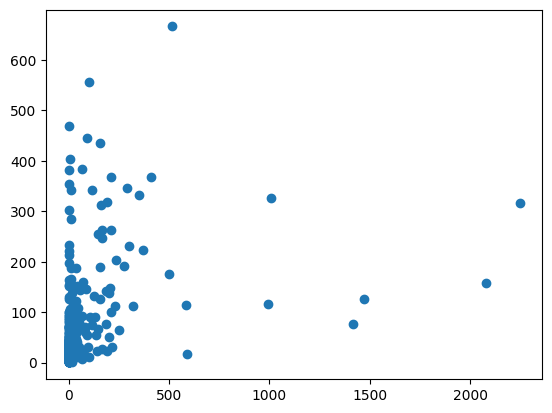

In [22]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred_test)

from sklearn.metrics import r2_score
r2_score(y_test, y_pred_test)

In [23]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score, KFold
from bayes_opt import BayesianOptimization
import numpy as np

hrz = 0

train_data = pd.read_csv(f'FireBurntArea_trainset_{hrz}Days.csv', header=0)
test_data = pd.read_csv(f'FireBurntArea_testset_{hrz}Days.csv', header=0)

sel_features = ['LC_Type1', 'avgLongitude', 'EVI', 'Albedo_BSA_nir', 'dayl', 'LST_Night_1km', 'Y', 'M', 'D', 'v_component_of_wind_10m', 'surface_pressure', 'snowmelt_sum']
sel_features = sel_features + [train_data.columns[-1]]
train_data = train_data.loc[:,sel_features]
test_data = test_data.loc[:,sel_features]

X_train, X_test = train_data.iloc[:,:-1], test_data.iloc[:,:-1]
y_train, y_test = np.squeeze(train_data.iloc[:,-1]), np.squeeze(test_data.iloc[:,-1])

# Scale features
X_train_scaled, X_test_scaled = scale_features(X_train, X_test)  

# Define the model evaluation function
def evaluate_model(learning_rate, max_iter, max_depth, min_samples_leaf, l2_regularization, max_leaf_nodes):
    # scores = cross_val_score(model, X_train_scaled, y_train, cv=10, scoring='accuracy', n_jobs=-1)
    
    # # Return the mean accuracy
    # return np.mean(scores)

    # Compute the cross-validated performance
    cv = KFold(n_splits=5)
    # Use the models trained during cross-validation for the test set
    test_predictions = np.zeros(len(X_test_scaled))
    for train_index, val_index in cv.split(X_train_scaled, y_train):
        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
         # Model parameters need to be integers where required
        model = HistGradientBoostingRegressor(
            learning_rate=max(learning_rate, 0.01),  # ensure learning_rate is at least 0.01
            max_iter=int(max_iter),
            max_depth=int(max_depth),
            min_samples_leaf=int(min_samples_leaf),
            l2_regularization=max(l2_regularization, 0),  # ensure l2_regularization is non-negative
            max_leaf_nodes=int(max_leaf_nodes)
        )
        model.fit(X_train_fold, y_train_fold)
        test_predictions += model.predict(X_test_scaled)
    
    # Average the predictions
    test_predictions /= cv.get_n_splits()
    
    # Evaluate testing performance
    MASE_test = mean_absolute_scaled_error(y_test, test_predictions, y_train)
    
    # Return the MASE
    return -MASE_test # Negate because Bayesian Optimization maximizes the function

# Bounds of hyperparameters for Bayesian Optimization
# pbounds = { #Step 1
#     'learning_rate': (0.01, 0.3),
#     'max_iter': (100, 1000),
#     'max_depth': (3, 10),
#     'min_samples_leaf': (1, 50),
#     'l2_regularization': (0.0, 1.0),
#     'max_leaf_nodes': (10, 100)}
pbounds = {  #Step 2
    'learning_rate': (0.01, 0.05),
    'max_iter': (100, 200),
    'max_depth': (5, 10),
    'min_samples_leaf': (1, 20),
    'l2_regularization': (0, 0.5),
    'max_leaf_nodes': (20, 40)}


# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=evaluate_model,
    pbounds=pbounds,
    random_state=42,
)

# Perform optimization
optimizer.maximize(
    init_points=10,  # Random exploration steps
    n_iter=100       # Optimization steps
#     acq='ei',        # Acquisition function (Expected Improvement)
)

# Best parameters found
print("Best parameters:", optimizer.max)


|   iter    |  target   | l2_reg... | learni... | max_depth | max_iter  | max_le... | min_sa... |
-------------------------------------------------------------------------------------------------
| 1         | -0.6822   | 0.1873    | 0.04803   | 8.66      | 159.9     | 23.12     | 3.964     |
| 2         | -0.6974   | 0.02904   | 0.04465   | 8.006     | 170.8     | 20.41     | 19.43     |
| 3         | -0.6997   | 0.4162    | 0.01849   | 5.909     | 118.3     | 26.08     | 10.97     |
| 4         | -0.6871   | 0.216     | 0.02165   | 8.059     | 113.9     | 25.84     | 7.961     |
| 5         | -0.7255   | 0.228     | 0.04141   | 5.998     | 151.4     | 31.85     | 1.883     |
| 6         | -0.6867   | 0.3038    | 0.01682   | 5.325     | 194.9     | 39.31     | 16.36     |
| 7         | -0.6865   | 0.1523    | 0.01391   | 8.421     | 144.0     | 22.44     | 10.41     |
| 8         | -0.6803   | 0.01719   | 0.04637   | 6.294     | 166.3     | 26.23     | 10.88     |
| 9         | -0.677

| 50        | -0.662    | 0.3162    | 0.0204    | 8.108     | 177.7     | 38.73     | 14.61     |
| 51        | -0.6728   | 0.4256    | 0.03402   | 8.625     | 178.8     | 37.57     | 14.12     |
| 52        | -0.6885   | 0.0       | 0.01      | 8.897     | 181.1     | 37.92     | 14.48     |
| 53        | -0.6764   | 0.4023    | 0.04156   | 5.453     | 104.5     | 38.16     | 12.89     |
| 54        | -0.6861   | 0.4898    | 0.02102   | 5.783     | 171.9     | 26.31     | 16.89     |
| 55        | -0.6608   | 0.1923    | 0.02158   | 9.442     | 179.1     | 38.75     | 14.82     |
| 56        | -0.6704   | 0.2013    | 0.01666   | 8.048     | 177.8     | 39.67     | 15.23     |
| 57        | -0.6642   | 0.2374    | 0.02494   | 9.685     | 178.6     | 38.72     | 14.68     |
| 58        | -0.6663   | 0.1048    | 0.02784   | 8.054     | 178.5     | 38.42     | 13.72     |
| 59        | -0.6618   | 0.1258    | 0.02338   | 8.608     | 177.6     | 39.41     | 13.86     |
| 60        | -0.670

| 101       | -0.6868   | 0.3911    | 0.04794   | 9.356     | 179.0     | 38.3      | 15.13     |
| 102       | -0.6824   | 0.1979    | 0.03406   | 9.343     | 191.4     | 29.78     | 4.425     |
| 103       | -0.701    | 0.05727   | 0.04942   | 9.788     | 166.6     | 23.5      | 11.63     |
| 104       | -0.6757   | 0.459     | 0.0203    | 9.057     | 179.2     | 29.73     | 6.29      |
| 105       | -0.683    | 0.1087    | 0.04781   | 7.182     | 148.2     | 33.33     | 16.08     |
| 106       | -0.7119   | 0.1536    | 0.0339    | 8.76      | 141.1     | 22.82     | 1.169     |
| 107       | -0.682    | 0.308     | 0.01127   | 9.146     | 177.8     | 39.2      | 14.8      |
| 108       | -0.6839   | 0.2751    | 0.04937   | 8.599     | 177.1     | 38.54     | 14.37     |
| 109       | -0.6705   | 0.3054    | 0.0202    | 7.754     | 177.9     | 39.89     | 12.63     |
| 110       | -0.7176   | 0.0805    | 0.04603   | 6.538     | 174.9     | 28.65     | 2.204     |
Best parameters: {'t

In [38]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, f1_score
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.ensemble import HistGradientBoostingRegressor
from scipy.stats import yeojohnson

model_final = HistGradientBoostingRegressor(
    learning_rate=0.021578173412383345,
    max_iter=179,
    max_depth=9,
    min_samples_leaf=14,
    l2_regularization=0.1923229365188724,
    max_leaf_nodes=38
)

for hrz in list([0,7,30,90]):
#     print(f'')
    train_data = pd.read_csv(f'FireBurntArea_trainset_{hrz}Days.csv', header=0)
    test_data = pd.read_csv(f'FireBurntArea_testset_{hrz}Days.csv', header=0)

    sel_features = ['LC_Type1', 'avgLongitude', 'EVI', 'Albedo_BSA_nir', 'dayl', 'LST_Night_1km', 'Y', 'M', 'D', 'v_component_of_wind_10m', 'surface_pressure', 'snowmelt_sum']# 'snow_cover'['LC_Type1', 'Elevation', 'NDVI', 'sur_refl_b01', 'sur_refl_b07', 'Albedo_BSA_nir', 'Albedo_WSA_shortwave', 'prcp', 'tmax', 'LST_Day_1km', 'M', 'S', 'v_component_of_wind_10m', 'surface_pressure', 'total_evaporation_sum']
    sel_features = sel_features + [train_data.columns[-1]]
    train_data = train_data.loc[:,sel_features]
    test_data = test_data.loc[:,sel_features]

    X_train, X_test = train_data.iloc[:,:-1], test_data.iloc[:,:-1]
    y_train, y_test = np.squeeze(train_data.iloc[:,-1]), np.squeeze(test_data.iloc[:,-1])

    # Scale features
    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)  
        
    print(f'{hrz}',end=';')

    # Model learning
    print(str(model_final).split('(')[0],end=';')

    # Perform stratified cross-validation and collect predictions for the training set
    start_train = time.time()
    cv = KFold(n_splits=10)
    y_pred_train_cv = cross_val_predict(model_final, X_train_scaled, y_train, cv=cv)
    end_train = time.time()

    # Evaluate training performance
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train_cv))
    mase_train = mean_absolute_scaled_error(y_train, y_pred_train_cv, y_train)
    train_duration = end_train - start_train
    
    print(f'{train_duration};{rmse_train};{mase_train}',end=';')

    # Use the models trained during cross-validation for the test set
    test_predictions = np.zeros(len(X_test_scaled))
    for train_index, val_index in cv.split(X_train_scaled, y_train):
        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        model_final.fit(X_train_fold, y_train_fold)
        test_predictions += model_final.predict(X_test_scaled)
    
    # Average the predictions
    test_predictions /= cv.get_n_splits()
    

    # Evaluate testing performance
    rmse_test = np.sqrt(mean_squared_error(y_test, test_predictions))
    mase_test = mean_absolute_scaled_error(y_test, test_predictions, y_train)
    test_duration = time.time() - start_train - train_duration
    print(f'{test_duration};{rmse_test};{mase_test}')#;{explained_variance_test};{r2_test}')

    #save resutls
    pd.DataFrame({'train_targs': y_train, 'train_preds': y_pred_train_cv}).to_csv(f"BurntAreaResults_{str(model_final).split('(')[0]}_hrz{hrz}_GA_trainresults.csv")

    pd.DataFrame({'test_targs': y_test, 'test_preds': test_predictions}).to_csv(f"BurntAreaResults_{str(model_final).split('(')[0]}_hrz{hrz}_GA_testresults.csv")

0;HistGradientBoostingRegressor;13.50004768371582;204.23046182720816;0.7752109817252617;13.548368215560913;190.5486941647569;0.6620866272547413
7;HistGradientBoostingRegressor;13.53366732597351;204.8318801843662;0.7764609429389743;14.087722301483154;195.17701352958784;0.717242965908051
30;HistGradientBoostingRegressor;13.713740825653076;203.394140026854;0.7888216771951194;14.381977558135986;194.5055222860449;0.735412193564084
90;HistGradientBoostingRegressor;13.552821636199951;201.9794707324865;0.7708208357879505;13.985600709915161;195.7579887967982;0.7207103227751501


In [32]:
y_train.shape, y_pred_train.shape

0        23.936773
1         0.250000
2         0.250000
3         8.515799
4        59.056457
           ...    
1651     24.396042
1652    155.192417
1653      0.250000
1654     21.802501
1655     22.214295
Name: totalArea_km2, Length: 1656, dtype: float64

## BENCHMARKING

In [61]:
import warnings, sys, os
warnings.simplefilter(action='ignore', category=FutureWarning)
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses
    
import pandas as pd
# pip install scikit-learn==1.4.0

In [62]:
# load data into pandas dataframe
import pandas as pd
import numpy as np
# !pip install sktime
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
import time

# !pip install PrettyTable
from prettytable import PrettyTable

models = [{'model': LinearRegression(), 'params': {}},
          {'model': SGDRegressor(max_iter=10000, random_state=42), 'params': {'alpha': 10.0 ** -np.arange(1, 7),
                                                                               'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
                                                                               'penalty': ['l2', 'l1', 'elasticnet'],
                                                                               'learning_rate': ['constant', 'optimal', 'invscaling']}},
          {'model': KNeighborsRegressor(n_jobs=-1), 'params': {'n_neighbors': range(3, 23, 3), 'weights': ['uniform', 'distance'], 'p': [1, 2]}},

          {'model': RandomForestRegressor(verbose=0, n_jobs=-1, random_state=42), 'params': {'n_estimators': [10, 20, 50, 70],
                                                        'max_depth': range(3,23,3),
                                                        'min_samples_split': [2, 4, 6],
                                                        'min_samples_leaf': [2, 4, 6]}},
#           {'model': ExtraTreesRegressor(verbose=0, n_jobs=-1, random_state=42), 'params': {'n_estimators': [10, 20, 50, 70],
#                                                         'max_depth': range(3,23,3),
#                                                         'min_samples_split': [2, 4, 6],
#                                                         'min_samples_leaf': [2, 4, 6]}},          
          {'model':LGBMRegressor(n_jobs=-1, verbose=-1,force_col_wise=True, random_state=42), 'params': {'learning_rate': [0.1, 0.01, 0.001],
                                                           'n_estimators': [100,200,500,1000],
                                                           'num_leaves': [20, 31, 40, 60, 80],
                                                           'min_data_in_leaf': range(50,300, 100)}},
          {'model':SVR(verbose=0), 'params':  {'C': [0.1, 1], #10, 100
                                      'gamma': [0.1, 0.01],#1, , 0.001
                                      'kernel': ['linear', 'rbf', 'sigmoid']}},# 'poly',
          {'model':MLPRegressor(verbose=False,max_iter=20000, random_state=42), 'params':  {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,50), (75,35)],
                                               'activation': ['relu','tanh'],#,'logistic'
                                               'alpha': [0.0001, 0.05]}}
          ]


# Function to scale features
def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

In [63]:
#read inputs 
print('Reading and processing RS inputs..')
data = pd.read_csv('FireBurntArea_datasetV4_0Days.csv', header=0)
data

Reading and processing RS inputs..


,LC_Type1,LC_Type2,LC_Type3,LC_Type4,LC_Type5,avgLongitude,avgLatitude,Elevation,Slope,Aspect,...,runoff_sum,total_evaporation_sum,snowfall_sum,snowmelt_sum,snow_depth,snow_density,snow_cover,dewpoint_temperature_2m,temperature_2m,totalArea_km2
0,8,8,4,4,4,-162.81695,62.953425,76,0.127839,275.667218,...,0.000868,-0.000535,0.000005,0.000000e+00,1.690267e-01,198.237289,100.000000,265.185745,269.474932,0.979713
1,8,8,4,4,4,-147.15870,64.785600,151,0.267640,346.948073,...,0.000046,-0.002125,0.000000,1.543760e-05,-7.345365e-24,154.937485,0.102783,276.366584,281.858940,0.295989
2,8,8,4,1,1,-148.53950,64.364500,174,0.289804,354.668166,...,0.000249,-0.003539,0.000000,0.000000e+00,-7.345365e-24,100.002263,0.000000,281.229359,291.656452,0.250000
3,7,7,2,1,5,-146.50850,63.993100,580,0.545915,285.295886,...,0.001994,-0.000478,0.000000,3.360212e-06,-7.345365e-24,161.781235,0.082926,270.544548,274.700846,0.250000
4,7,7,2,1,5,-146.35220,64.024000,453,0.447008,299.675079,...,0.000587,-0.000995,0.000000,4.351754e-03,2.640788e-02,267.080388,26.630371,273.304184,282.790248,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2065,8,8,4,1,1,-145.93715,64.643550,313,0.400006,334.382444,...,0.000534,-0.002531,0.000000,7.450581e-09,-7.345365e-24,105.813136,0.000000,280.222176,287.991054,0.830562
2066,15,15,9,7,10,-161.88630,55.418800,2186,0.025017,270.000000,...,0.006850,-0.000637,0.000000,6.294075e-03,1.344824e+01,180.705714,40.343750,281.538507,282.846760,0.250000
2067,15,15,9,7,10,-161.89350,55.417900,2479,0.025017,270.000000,...,0.006829,-0.001089,0.000000,6.279286e-03,1.344824e+01,180.694321,40.343750,278.835497,280.776448,0.250000
2068,15,15,9,7,10,-161.89090,55.422600,2100,0.025017,270.000000,...,0.004876,-0.000546,0.000000,3.418032e-03,1.344824e+01,194.436834,40.363200,275.874074,277.500503,0.250000


In [147]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import numpy as np

print('Splitting to train and test sets..')
all_indices = list(range(len(data)))

train_ind, test_ind = train_test_split(all_indices, test_size=0.2, random_state=42)

X_train, X_test = data.iloc[train_ind,:-1], data.iloc[test_ind,:-1]
y_train, y_test = np.squeeze(data.iloc[train_ind,-1]), np.squeeze(data.iloc[test_ind,-1])

# Scale features
X_train_scaled, X_test_scaled = scale_features(X_train, X_test)  

print('training set: ',X_train_scaled.shape, y_train.shape, ', testing set: ',X_test_scaled.shape, y_test.shape)

Splitting to train and test sets..
training set:  (3266, 45) (3266,) , testing set:  (817, 45) (817,)


In [64]:
import numpy as np
from sklearn.metrics import mean_absolute_error

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    """
    Compute the Mean Absolute Scaled Error (MASE).
    
    Parameters:
    y_true: array-like of shape (n_samples,) - Ground truth (correct) target values.
    y_pred: array-like of shape (n_samples,) - Estimated target values.
    y_train: array-like of shape (n_samples,) - Training data to calculate the naive forecast.

    Returns:
    mase: float - Mean Absolute Scaled Error.
    """
    # Check for the length of y_train
    if len(y_train) < 2:
        raise ValueError("Length of y_train should be at least 2.")

    # Calculate MAE for the predictions
    mae = mean_absolute_error(y_true, y_pred)

    # Calculate the MAE of the one-step naive forecast method
    naive_forecast = y_train[:-1]
    naive_true = y_train[1:]
    mae_naive = mean_absolute_error(naive_true, naive_forecast)

    # Handle the case when naive MAE is zero to avoid division by zero
    if mae_naive == 0:
        return np.inf if mae != 0 else 0

    # Calculate MASE
    mase = mae / mae_naive

    return mase

In [72]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV


print(f'Target;model;bestparam;inputs;trainDur;RMSE;MASE;testDur;RMSE;MASE')
for hrz in list([0]):#,7,30,90 

    print(f'')
    train_data = pd.read_csv(f'FireBurntArea_trainsetV4_{hrz}Days.csv', header=0)
    test_data = pd.read_csv(f'FireBurntArea_testsetV4_{hrz}Days.csv', header=0)

    indcz = train_data["totalArea_km2"]>=100

    sel_features = ['LC_Type5', 'Slope', 'Aspect', 'prcp', 'tmin', 'LST_Night_1km', 'Y', 'M', 'D', 'S']
    sel_features = sel_features + [train_data.columns[-1]]
    train_data = train_data.loc[indcz,sel_features]
    test_data = test_data.loc[indcz,sel_features]

    X_train, X_test = train_data.iloc[:,:-1], test_data.iloc[:,:-1]
    y_train, y_test = np.squeeze(train_data.iloc[:,-1]), np.squeeze(test_data.iloc[:,-1])

    # Scale features
    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)  

    print(f'{hrz}',end=';')
    # Model learning
    for model in models:
        print(str(model['model']).split('(')[0],end=';')

        # hyperparameter tuning
        if str(model['model']).split('(')[0] != 'LinearRegression' and str(model['model']).split('(')[0] != 'ExtraTreesRegressor' and str(model['model']).split('(')[0] != 'LGBMRegressor':#
            model_final = GridSearchCV(model['model'], model['params'], cv=10, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)#n_iter=15,
        elif str(model['model']).split('(')[0] == 'ExtraTreesRegressor':
            model_final = ExtraTreesRegressor(n_jobs=-1, random_state=42, max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=70)
        elif str(model['model']).split('(')[0] == 'LGBMRegressor':
            model_final = LGBMRegressor(learning_rate=0.01, min_data_in_leaf=50, n_estimators=1000, num_leaves=60, n_jobs=-1, verbose=-1,force_col_wise=True)
        else:
            model_final = model['model']
        #     model_final = GridSearchCV(model['model'], model['params'], cv=10, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)#n_iter=15,

        # Train model
        start_train = time.time()
        model_final.fit(X_train_scaled, y_train)
        end_train = time.time()

        # Evaluate training performance
        y_pred_train = model_final.predict(X_train_scaled)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        mase_train = mean_absolute_scaled_error(y_train, y_pred_train, y_train)
        train_duration = end_train - start_train

        if str(model['model']).split('(')[0] != 'LinearRegression' and str(model['model']).split('(')[0] != 'ExtraTreesRegressor' and str(model['model']).split('(')[0] != 'LGBMRegressor':
            print(f'{model_final.best_params_};GA;{train_duration};{rmse_train};{mase_train}',end=';')
        elif str(model['model']).split('(')[0] == 'ExtraTreesRegressor':
            print(f'max_depth: 15, min_samples_leaf: 4, min_samples_split: 2, n_estimators: 70;GA;{train_duration};{rmse_train};{mase_train}',end=';')
        elif str(model['model']).split('(')[0] == 'LGBMRegressor':
            print(f'learning_rate: 0.01, min_data_in_leaf: 50, n_estimators: 1000, num_leaves: 60;GA;{train_duration};{rmse_train};{mase_train}',end=';')
        else:
            print(f'-;GA;{train_duration};{rmse_train};{mase_train}',end=';')

        # Test model
        start_test = time.time()
        y_pred_test = model_final.predict(X_test_scaled)
        end_test = time.time()

        # Evaluate testing performance
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        mase_test = mean_absolute_scaled_error(y_test, y_pred_test, y_train)
        test_duration = end_test - start_test

        print(f'{rmse_test};{mase_test}')#{test_duration};


Target;model;bestparam;inputs;trainDur;RMSE;MASE;testDur;RMSE;MASE

0;LinearRegression;-;GA;0.0009489059448242188;471.34334717793865;0.7066299937544964;411.7906547151093;0.9437844310034615
SGDRegressor;{'alpha': 9.999999999999999e-05, 'learning_rate': 'optimal', 'loss': 'epsilon_insensitive', 'penalty': 'l1'};GA;5.169234275817871;501.6521432938197;0.616031620480827;283.24286681394534;0.6299491971216785
KNeighborsRegressor;{'n_neighbors': 21, 'p': 1, 'weights': 'uniform'};GA;0.4251210689544678;466.9650115411687;0.7239749224892297;418.8858528706802;0.9638462428014096
RandomForestRegressor;

KeyboardInterrupt: 

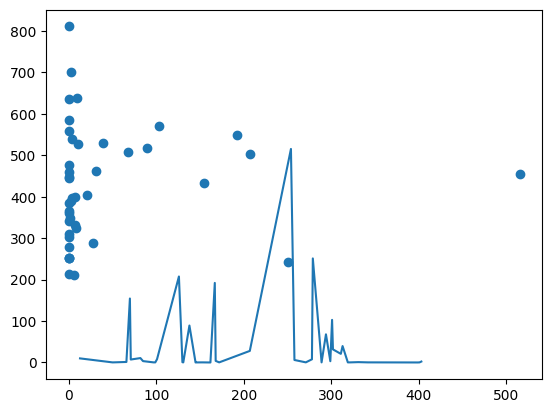

In [74]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred_test)

from sklearn.metrics import r2_score
r2_score(y_test, y_pred_test)

plt.plot(y_test)

# TASK 3 - Fire duration : model learning (regression)

In [48]:
for hrz in list([0,7,30,90]):
    data = pd.read_csv(f'FireDuration_datasetV4_{hrz}Days.csv', header=0)

    #     print('Splitting to train and test sets..')
    all_indices = list(range(len(data)))

    train_ind, test_ind = train_test_split(all_indices, test_size=0.2, random_state=42, stratify=None)

    trainset, testset = data.iloc[train_ind,:], data.iloc[test_ind,:]
    trainset.to_csv(f'FireDuration_trainsetV4_{hrz}Days.csv')
    testset.to_csv(f'FireDuration_testsetV4_{hrz}Days.csv')

## Task x: multivariate deep learning benchmark

In [14]:
#get data for time series deep learning prediction 
hrz = 0
data_train = pd.read_csv(f'FireDuration_trainsetV4_{hrz}Days.csv', header=0,index_col=0)
data_test = pd.read_csv(f'FireDuration_testsetV4_{hrz}Days.csv', header=0,index_col=0)

inlen = 10
addlen = 30#30#7#0

tmp1 = pd.read_csv(f'Fires_task1_preprocessed_targets.csv', header=0)
tmp1 = tmp1[tmp1['isFire']==1]

features = ['LC_Type5', 'Slope', 'sur_refl_b07', 'Albedo_BSA_nir', 'tmax', 'tmin', 'Y', 'M', 'D', 'S', 'temperature_2m']
for feature in features:
    # dynamically create the variable
    tmp = pd.read_csv(f'Fires_task1_preprocessed_{feature}.csv', header=0)
    tmp = tmp.iloc[tmp1.index,:]
    if addlen == 0:
        exec(f'{feature}_train, {feature}_test = to3d(tmp.iloc[data_train.index,:].iloc[:,-inlen:].values),to3d(tmp.iloc[data_test.index,:].iloc[:,-inlen:].values)')
    else:
        exec(f'{feature}_train, {feature}_test = to3d(tmp.iloc[data_train.index,:].iloc[:,-inlen-addlen:-addlen].values),to3d(tmp.iloc[data_test.index,:].iloc[:,-inlen-addlen:-addlen].values)')
        

In [15]:
from tsai.all import *
from fastai.callback.all import *
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, f1_score

# models = {'TSSequencerPlus','ConvTranPlus','TransformerGRUPlus','TransformerLSTMPlus','TransformerRNNPlus','MGRU_FCNPlus','MLSTM_FCNPlus','MRNN_FCNPlus','GRU_FCNPlus','LSTM_FCNPlus','RNN_FCNPlus','HydraMultiRocketPlus','MultiRocketPlus','TSiTPlus','XCMPlus','XceptionTimePlus','ResNetPlus','LSTMAttention','RNNAttention','GRUAttention','InceptionTimePlus','TSTPlus','XCMPlus','LSTMPlus','GRUPlus'}#,'MiniRocketPlus',
models = {'TSSequencerPlus','ConvTranPlus'}#,
seed = 42

target_train = to3d(data_train.iloc[:,-1].values)
target_test = to3d(data_test.iloc[:,-1].values)
target_train = np.transpose(target_train, (2, 0, 1))
target_test = np.transpose(target_test, (2, 0, 1))

X_train, X_test = np.concatenate([LC_Type5_train[:,:,:],Slope_train[:,:,:],sur_refl_b07_train[:,:,:],Albedo_BSA_nir_train[:,:,:],tmax_train[:,:,:],tmin_train[:,:,:],Y_train[:,:,:],M_train[:,:,:],D_train[:,:,:],S_train[:,:,:],temperature_2m_train[:,:,:]],axis=1), np.concatenate([LC_Type5_test[:,:,:],Slope_test[:,:,:],sur_refl_b07_test[:,:,:],Albedo_BSA_nir_test[:,:,:],tmax_test[:,:,:],tmin_test[:,:,:],Y_test[:,:,:],M_test[:,:,:],D_test[:,:,:],S_test[:,:,:],temperature_2m_test[:,:,:]],axis=1)
y_train, y_test = target_train, target_test

print('training set: ',X_train.shape, y_train.shape, ', testing set: ',X_test.shape, y_test.shape)
splits = get_splits(y_train, valid_size=.2, stratify=False, random_state=seed, shuffle=True)
tfms  = [None, [TSRegression()]]
batch_tfms = TSStandardize(by_sample=True)
dsets = TSDatasets(X_train, y_train, tfms=tfms, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=2048)
set_seed(seed)
par = {}

tbl = pd.DataFrame(columns=['input_length', 'model', 'total_params', 'epochs', 'train_time', 'rmse_train', 'mase_train', 'rmse_test', 'mase_test'])

epchs = 50
tbl_ind = 0
for model_name in models:
    print(model_name)
    #Model learning
    learn = TSRegressor(X_train, y_train, splits=splits, tfms=tfms, batch_tfms=batch_tfms, 
                 bs=2048, arch=model_name,
                 arch_config=par, metrics=[rmse],
                 cbs=[ShowGraph(),SaveModel('valid_loss')],#ShowGraph(),SaveModel(),EarlyStoppingCallback(monitor='_rmse', comp=np.less,min_delta=0.0001, patience=6)
                 seed=seed)

#     lr = learn.lr_find()
    learning_rate = 3e-3#lr.valley

    # Train model
    start = time.time()
    learn.fit_one_cycle(epchs, learning_rate)
    train_duration = time.time() - start

    # Evaluate on training set
    _, train_targets, train_preds = learn.get_preds(dl=dls.valid, with_decoded=True, save_preds=None, save_targs=None)
    rmse_train = np.sqrt(mean_squared_error(np.squeeze(train_targets), np.squeeze(train_preds)))
    mase_train = mean_absolute_scaled_error(np.squeeze(train_targets), np.squeeze(train_preds), np.squeeze(train_targets))

    vals = learn.recorder.values[-1]

    valid_dl = dls.valid

    # Labeled test data
    test_ds = valid_dl.dataset.add_test(X_test, y_test)
    test_dl = valid_dl.new(test_ds)
    _, test_targetdata, test_predsdata = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)

    d = pd.DataFrame(test_targetdata.ravel())
    dp = pd.DataFrame(test_predsdata.ravel())

    # Calculate the overall accuracy
    rmse_test = np.sqrt(mean_squared_error(d, dp))
    mase_test = mean_absolute_scaled_error(d, dp, d)


    tbl.loc[tbl_ind] = ['10days',model_name, count_parameters(learn, model_name), str(epchs) + ' (3e-3)', float(train_duration), rmse_train, mase_train, rmse_test, mase_test]
    tbl.sort_values(by='rmse_test', ascending=False, kind='stable', ignore_index=True, inplace=True)
    clear_output()
    tbl_ind += 1

display(tbl)


,input_length,model,total_params,epochs,train_time,rmse_train,mase_train,rmse_test,mase_test
0,10days,ConvTranPlus,21625,50 (3e-3),8.362222,9.976322,0.744286,9.290792,0.710885
1,10days,TSSequencerPlus,217261,50 (3e-3),11.732312,9.754762,0.825006,9.113955,0.796974


In [11]:
display(tbl)


,input_length,model,total_params,epochs,train_time,rmse_train,mase_train,rmse_test,mase_test
0,10days,ConvTranPlus,21625,300 (3e-3),116.811721,11.291058,0.763145,10.766401,0.775051


### TASK 3 - no remote sensing / reanalysis data 

In [54]:
# load data into pandas dataframe
import pandas as pd
import numpy as np
# !pip install sktime
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
import time

# !pip install PrettyTable
from prettytable import PrettyTable

models = [
    {'model': HistGradientBoostingRegressor(random_state=42)}
#     {'model': ExtraTreesRegressor(verbose=0, n_jobs=-1, random_state=42), 'params': {'n_estimators': [10, 20, 50, 70],
#                                                         'max_depth': range(3,23,3),
#                                                         'min_samples_split': [2, 4, 6],
#                                                         'min_samples_leaf': [2, 4, 6]}},          
]


# Function to scale features
def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

In [55]:
import numpy as np
from sklearn.metrics import mean_absolute_error

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    """
    Compute the Mean Absolute Scaled Error (MASE).
    
    Parameters:
    y_true: array-like of shape (n_samples,) - Ground truth (correct) target values.
    y_pred: array-like of shape (n_samples,) - Estimated target values.
    y_train: array-like of shape (n_samples,) - Training data to calculate the naive forecast.

    Returns:
    mase: float - Mean Absolute Scaled Error.
    """
    # Check for the length of y_train
    if len(y_train) < 2:
        raise ValueError("Length of y_train should be at least 2.")

    # Calculate MAE for the predictions
    mae = mean_absolute_error(y_true, y_pred)

    # Calculate the MAE of the one-step naive forecast method
    naive_forecast = y_train[:-1]
    naive_true = y_train[1:]
    mae_naive = mean_absolute_error(naive_true, naive_forecast)

    # Handle the case when naive MAE is zero to avoid division by zero
    if mae_naive == 0:
        return np.inf if mae != 0 else 0

    # Calculate MASE
    mase = mae / mae_naive

    return mase

In [57]:
for hrz in list([0,7,30,90]):
    train_data = pd.read_csv(f'FireDuration_trainset_{hrz}Days.csv', header=0)
    test_data = pd.read_csv(f'FireDuration_testset_{hrz}Days.csv', header=0)

    sel_features = ['avgLongitude', 'avgLatitude', 'S']
    sel_features = sel_features + ['Duration']
    train_data = train_data.loc[:,sel_features]
    test_data = test_data.loc[:,sel_features]

    X_train, X_test = train_data.iloc[:,:-1], test_data.iloc[:,:-1]
    y_train, y_test = np.squeeze(train_data.iloc[:,-1]), np.squeeze(test_data.iloc[:,-1])

    # Scale features
    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)  

    print(f'{hrz}',end=';')
    # Model learning
    for model in models:
        y_pred_train, rmse_train, mase_train, y_pred_test, rmse_test, mase_test, = [], [], [], [], [], []
        print(str(model['model']).split('(')[0],end=';')

        # hyperparameter tuning
        model_final = HistGradientBoostingRegressor(random_state=42)#GridSearchCV(model['model'], model['params'], cv=10, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)#n_iter=15,

        # Train model
        start_train = time.time()
        model_final.fit(X_train_scaled, y_train)
        end_train = time.time()

        # Evaluate training performance
        y_pred_train = model_final.predict(X_train_scaled)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        mase_train = mean_absolute_scaled_error(y_train, y_pred_train, y_train)
        train_duration = end_train - start_train

        print(f'-;noRSREinputs;{train_duration};{rmse_train};{mase_train}',end=';')

        # Test model
        start_test = time.time()
        y_pred_test = model_final.predict(X_test_scaled)
        end_test = time.time()

        # Evaluate testing performance
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        mase_test = mean_absolute_scaled_error(y_test, y_pred_test, y_train)
        test_duration = end_test - start_test

        print(f'{test_duration};{rmse_test};{mase_test}')

#         #save resutls
#         pd.DataFrame({'train_targs': y_train, 'train_preds': y_pred_train}).to_csv(f"DurationResults_{str(model['model']).split('(')[0]}_hrz{hrz}_noRSREinputs_trainresults.csv")

#         pd.DataFrame({'test_targs': y_test, 'test_preds': y_pred_test}).to_csv(f"DurationResults_{str(model['model']).split('(')[0]}_hrz{hrz}_noRSREinputs_testresults.csv")

0;HistGradientBoostingRegressor;-;noRSREinputs;0.5922622680664062;6.974523432480931;0.5924482821014888;0.003874063491821289;8.888748764645424;0.7253639576814551
7;HistGradientBoostingRegressor;-;noRSREinputs;0.5985901355743408;6.800949238348113;0.5746583498237937;0.003155946731567383;9.045612487527869;0.7328094095317707
30;HistGradientBoostingRegressor;-;noRSREinputs;0.5983340740203857;7.0495429212808896;0.5905367368218165;0.003135204315185547;9.08486559577076;0.7346361533931834
90;HistGradientBoostingRegressor;-;noRSREinputs;0.6201190948486328;6.999774019873795;0.5925626554339164;0.003186464309692383;8.968927391825524;0.7328314680336506


## TASK 3 - Class Distribution features (3) + ET 

In [17]:
for hrz in list([0,7,30,90]):
    train_data = pd.read_csv(f'FireDuration_trainsetV4_{hrz}Days.csv', header=0)
    test_data = pd.read_csv(f'FireDuration_testsetV4_{hrz}Days.csv', header=0)

    sel_features = ['snowfall_sum']
    sel_features = sel_features + ['Duration']
    train_data = train_data.loc[:,sel_features]
    test_data = test_data.loc[:,sel_features]

    X_train, X_test = train_data.iloc[:,:-1], test_data.iloc[:,:-1]
    y_train, y_test = np.squeeze(train_data.iloc[:,-1]), np.squeeze(test_data.iloc[:,-1])

    # Scale features
    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)  

    print(f'{hrz}',end=';')
    # Model learning
    for model in models:
        y_pred_train, rmse_train, mase_train, y_pred_test, rmse_test, mase_test, = [], [], [], [], [], []
        print(str(model['model']).split('(')[0],end=';')

        # hyperparameter tuning
        model_final = GridSearchCV(model['model'], model['params'], cv=10, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)#n_iter=15,

        # Train model
        start_train = time.time()
        model_final.fit(X_train_scaled, y_train)
        end_train = time.time()

        # Evaluate training performance
        y_pred_train = model_final.predict(X_train_scaled)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        mase_train = mean_absolute_scaled_error(y_train, y_pred_train, y_train)
        train_duration = end_train - start_train

        print(f'{model_final.best_params_};CD;{train_duration};{rmse_train};{mase_train}',end=';')

        # Test model
        start_test = time.time()
        y_pred_test = model_final.predict(X_test_scaled)
        end_test = time.time()

        # Evaluate testing performance
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        mase_test = mean_absolute_scaled_error(y_test, y_pred_test, y_train)
        test_duration = end_test - start_test

        print(f'{test_duration};{rmse_test};{mase_test}')

        #save resutls
        pd.DataFrame({'train_targs': y_train, 'train_preds': y_pred_train}).to_csv(f"DurationResults_{str(model['model']).split('(')[0]}_hrz{hrz}_CD5inputs_trainresults.csv")

        pd.DataFrame({'test_targs': y_test, 'test_preds': y_pred_test}).to_csv(f"DurationResults_{str(model['model']).split('(')[0]}_hrz{hrz}_CD5inputs_testresults.csv")

0;ExtraTreesClassifier;{'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 50};CD;8.165966272354126;9.907025516741742;0.6808524215287244;0.01480865478515625;9.560890545306105;0.6629374052707897
7;ExtraTreesClassifier;{'max_depth': 12, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 10};CD;8.086158752441406;9.993113570883686;1.059194659852688;0.0048487186431884766;9.671163371910515;1.0425066995028311
30;ExtraTreesClassifier;{'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 10};CD;8.14646029472351;13.954874652609687;1.4889096388615057;0.0049588680267333984;13.43691648547691;1.4462898969876061
90;ExtraTreesClassifier;{'max_depth': 21, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 70};CD;8.627268075942993;20.781428093930128;2.004273120254148;0.018323659896850586;20.732597032454592;2.2001930469105573


## TASK 3 - remote sensing / reanalysis data + GA

In [41]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score, KFold
from bayes_opt import BayesianOptimization
import numpy as np

hrz = 0

train_data = pd.read_csv(f'FireDuration_trainset_{hrz}Days.csv', header=0)
test_data = pd.read_csv(f'FireDuration_testset_{hrz}Days.csv', header=0)

sel_features = ['LC_Type1', 'avgLongitude', 'avgLatitude', 'Slope', 'NDVI', 'Albedo_WSA_nir', 'Albedo_WSA_shortwave', 'prcp', 'srad', 'tmax', 'Y', 'M', 'D', 'v_component_of_wind_10m', 'runoff_sum', 'snow_depth', 'dewpoint_temperature_2m']
sel_features = sel_features + [train_data.columns[-1]]
train_data = train_data.loc[:,sel_features]
test_data = test_data.loc[:,sel_features]

X_train, X_test = train_data.iloc[:,:-1], test_data.iloc[:,:-1]
y_train, y_test = np.squeeze(train_data.iloc[:,-1]), np.squeeze(test_data.iloc[:,-1])

# Scale features
X_train_scaled, X_test_scaled = scale_features(X_train, X_test)  

# Define the model evaluation function
def evaluate_model(learning_rate, max_iter, max_depth, min_samples_leaf, l2_regularization, max_leaf_nodes):
    # scores = cross_val_score(model, X_train_scaled, y_train, cv=10, scoring='accuracy', n_jobs=-1)
    
    # # Return the mean accuracy
    # return np.mean(scores)

    # Compute the cross-validated performance
    cv = KFold(n_splits=5)
    # Use the models trained during cross-validation for the test set
    test_predictions = np.zeros(len(X_test_scaled))
    for train_index, val_index in cv.split(X_train_scaled, y_train):
        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
         # Model parameters need to be integers where required
        model = HistGradientBoostingRegressor(
            learning_rate=max(learning_rate, 0.01),  # ensure learning_rate is at least 0.01
            max_iter=int(max_iter),
            max_depth=int(max_depth),
            min_samples_leaf=int(min_samples_leaf),
            l2_regularization=max(l2_regularization, 0),  # ensure l2_regularization is non-negative
            max_leaf_nodes=int(max_leaf_nodes)
        )
        model.fit(X_train_fold, y_train_fold)
        test_predictions += model.predict(X_test_scaled)
    
    # Average the predictions
    test_predictions /= cv.get_n_splits()
    
    # Evaluate testing performance
    MASE_test = mean_absolute_scaled_error(y_test, test_predictions, y_train)
    
    # Return the MASE
    return -MASE_test # Negate because Bayesian Optimization maximizes the function

# Bounds of hyperparameters for Bayesian Optimization
# pbounds = { #Step 1
#     'learning_rate': (0.01, 0.3),
#     'max_iter': (100, 1000),
#     'max_depth': (3, 10),
#     'min_samples_leaf': (1, 50),
#     'l2_regularization': (0.0, 1.0),
#     'max_leaf_nodes': (10, 100)}
pbounds = {  #Step 2
    'learning_rate': (0.04, 0.1),
    'max_iter': (150, 200),
    'max_depth': (7, 10),
    'min_samples_leaf': (1, 15),
    'l2_regularization': (0.4, 0.7),
    'max_leaf_nodes': (20, 60)}


# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=evaluate_model,
    pbounds=pbounds,
    random_state=42,
)

# Perform optimization
optimizer.maximize(
    init_points=10,  # Random exploration steps
    n_iter=100       # Optimization steps
#     acq='ei',        # Acquisition function (Expected Improvement)
)

# Best parameters found
print("Best parameters:", optimizer.max)


|   iter    |  target   | l2_reg... | learni... | max_depth | max_iter  | max_le... | min_sa... |
-------------------------------------------------------------------------------------------------
| 1         | -0.5361   | 0.5124    | 0.09704   | 9.196     | 179.9     | 26.24     | 3.184     |
| 2         | -0.5336   | 0.4174    | 0.09197   | 8.803     | 185.4     | 20.82     | 14.58     |
| 3         | -0.5295   | 0.6497    | 0.05274   | 7.545     | 159.2     | 32.17     | 8.347     |
| 4         | -0.5289   | 0.5296    | 0.05747   | 8.836     | 157.0     | 31.69     | 6.129     |
| 5         | -0.5354   | 0.5368    | 0.08711   | 7.599     | 175.7     | 43.7      | 1.65      |
| 6         | -0.5329   | 0.5823    | 0.05023   | 7.195     | 197.4     | 58.63     | 12.32     |
| 7         | -0.5381   | 0.4914    | 0.04586   | 9.053     | 172.0     | 24.88     | 7.932     |
| 8         | -0.5325   | 0.4103    | 0.09456   | 7.776     | 183.1     | 32.47     | 8.281     |
| 9         | -0.531

| 51        | -0.5257   | 0.7       | 0.04784   | 8.967     | 198.6     | 42.68     | 6.78      |
| 52        | -0.5229   | 0.5067    | 0.05923   | 8.341     | 150.2     | 43.42     | 4.773     |
| 53        | -0.5318   | 0.4344    | 0.1       | 10.0      | 151.0     | 41.04     | 1.796     |
| 54        | -0.5236   | 0.7       | 0.1       | 10.0      | 150.0     | 42.28     | 7.762     |
| 55        | -0.5246   | 0.6809    | 0.05659   | 9.491     | 167.4     | 47.7      | 6.375     |
| 56        | -0.531    | 0.5576    | 0.1       | 8.763     | 150.1     | 48.52     | 6.439     |
| 57        | -0.5172   | 0.4604    | 0.04657   | 9.607     | 190.6     | 48.55     | 4.661     |
| 58        | -0.529    | 0.6282    | 0.05079   | 7.737     | 190.6     | 49.29     | 2.234     |
| 59        | -0.5258   | 0.4       | 0.08207   | 10.0      | 191.6     | 48.54     | 7.447     |
| 60        | -0.5185   | 0.4       | 0.04      | 10.0      | 188.8     | 46.03     | 4.664     |
| 61        | -0.523

| 102       | -0.5315   | 0.5697    | 0.06153   | 9.978     | 188.4     | 45.6      | 3.731     |
| 103       | -0.5177   | 0.5222    | 0.09818   | 9.59      | 189.7     | 48.73     | 5.588     |
| 104       | -0.521    | 0.6583    | 0.09751   | 8.966     | 189.5     | 47.92     | 4.984     |
| 105       | -0.5223   | 0.6635    | 0.09897   | 9.85      | 188.9     | 49.96     | 4.509     |
| 106       | -0.5146   | 0.4804    | 0.09921   | 9.638     | 190.6     | 48.49     | 5.569     |
| 107       | -0.5193   | 0.5176    | 0.0581    | 8.767     | 190.5     | 48.41     | 5.334     |
| 108       | -0.5208   | 0.7       | 0.04788   | 8.981     | 196.9     | 40.99     | 4.942     |
| 109       | -0.5329   | 0.5334    | 0.06263   | 9.67      | 195.6     | 41.49     | 3.567     |
| 110       | -0.5238   | 0.4671    | 0.08499   | 7.572     | 196.8     | 40.72     | 4.123     |
Best parameters: {'target': -0.5110944246076552, 'params': {'l2_regularization': 0.7, 'learning_rate': 0.1, 'max_depth

In [43]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, f1_score
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.ensemble import HistGradientBoostingRegressor
from scipy.stats import yeojohnson

model_final = HistGradientBoostingRegressor(
    learning_rate=0.1,
    max_iter=191,
    max_depth=10,
    min_samples_leaf=4,
    l2_regularization=0.7,
    max_leaf_nodes=49
)

for hrz in list([0,7,30,90]):
#     print(f'')
    train_data = pd.read_csv(f'FireDuration_trainset_{hrz}Days.csv', header=0)
    test_data = pd.read_csv(f'FireDuration_testset_{hrz}Days.csv', header=0)

    sel_features = ['LC_Type1', 'avgLongitude', 'avgLatitude', 'Slope', 'NDVI', 'Albedo_WSA_nir', 'Albedo_WSA_shortwave', 'prcp', 'srad', 'tmax', 'Y', 'M', 'D', 'v_component_of_wind_10m', 'runoff_sum', 'snow_depth', 'dewpoint_temperature_2m']
    sel_features = sel_features + [train_data.columns[-1]]
    train_data = train_data.loc[:,sel_features]
    test_data = test_data.loc[:,sel_features]

    X_train, X_test = train_data.iloc[:,:-1], test_data.iloc[:,:-1]
    y_train, y_test = np.squeeze(train_data.iloc[:,-1]), np.squeeze(test_data.iloc[:,-1])

    # Scale features
    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)  
        
    print(f'{hrz}',end=';')

    # Model learning
    print(str(model_final).split('(')[0],end=';')

    # Perform stratified cross-validation and collect predictions for the training set
    start_train = time.time()
    cv = KFold(n_splits=10)
    y_pred_train_cv = cross_val_predict(model_final, X_train_scaled, y_train, cv=cv)
    end_train = time.time()

    # Evaluate training performance
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train_cv))
    mase_train = mean_absolute_scaled_error(y_train, y_pred_train_cv, y_train)
    train_duration = end_train - start_train
    
    print(f'{train_duration};{rmse_train};{mase_train}',end=';')

    # Use the models trained during cross-validation for the test set
    test_predictions = np.zeros(len(X_test_scaled))
    for train_index, val_index in cv.split(X_train_scaled, y_train):
        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        model_final.fit(X_train_fold, y_train_fold)
        test_predictions += model_final.predict(X_test_scaled)
    
    # Average the predictions
    test_predictions /= cv.get_n_splits()
    

    # Evaluate testing performance
    rmse_test = np.sqrt(mean_squared_error(y_test, test_predictions))
    mase_test = mean_absolute_scaled_error(y_test, test_predictions, y_train)
    test_duration = time.time() - start_train - train_duration
    print(f'{test_duration};{rmse_test};{mase_test}')#;{explained_variance_test};{r2_test}')

    #save resutls
    pd.DataFrame({'train_targs': y_train, 'train_preds': y_pred_train_cv}).to_csv(f"DurationResults_{str(model_final).split('(')[0]}_hrz{hrz}_GA_trainresults.csv")
    pd.DataFrame({'test_targs': y_test, 'test_preds': test_predictions}).to_csv(f"DurationResults_{str(model_final).split('(')[0]}_hrz{hrz}_GA_testresults.csv")

0;HistGradientBoostingRegressor;18.508612632751465;7.863895174701538;0.629001365045382;18.723593711853027;6.68058279035762;0.5244993295147108
7;HistGradientBoostingRegressor;18.744860887527466;8.293317158943816;0.655528917935124;19.09642481803894;7.143049561445873;0.5671342277589989
30;HistGradientBoostingRegressor;19.026068210601807;7.99821126842675;0.623113616256575;19.91617441177368;6.688260805984213;0.5300665224831776
90;HistGradientBoostingRegressor;19.50198006629944;7.937498011237581;0.6244051341030504;18.917105197906494;7.034268283318731;0.5455310866237725


In [25]:
for hrz in list([0,7,30,90]):
#     print(f'')
    train_data = pd.read_csv(f'FireDuration_trainset_{hrz}Days.csv', header=0)
    test_data = pd.read_csv(f'FireDuration_testset_{hrz}Days.csv', header=0)

    sel_features = ['LC_Type5', 'Slope', 'sur_refl_b07', 'Albedo_BSA_nir', 'tmax', 'tmin', 'Y', 'M', 'D', 'S', 'temperature_2m']
    sel_features = sel_features + [train_data.columns[-1]]
    train_data = train_data.loc[:,sel_features]
    test_data = test_data.loc[:,sel_features]

    X_train, X_test = train_data.iloc[:,:-1], test_data.iloc[:,:-1]
    y_train, y_test = np.squeeze(train_data.iloc[:,-1]), np.squeeze(test_data.iloc[:,-1])

    # Scale features
    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)  

    print(f'{hrz}',end=';')
    # Model learning
    for model in models:
        y_pred_train, rmse_train, mase_train, y_pred_test, rmse_test, mase_test, = [], [], [], [], [], []
        print(str(model['model']).split('(')[0],end=';')

        # hyperparameter tuning
        model_final = ExtraTreesRegressor(n_jobs=-1, random_state=42, max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=50)

        # Train model
        start_train = time.time()
        model_final.fit(X_train_scaled, y_train)
        end_train = time.time()

        # Evaluate training performance
        y_pred_train = model_final.predict(X_train_scaled)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        mase_train = mean_absolute_scaled_error(y_train, y_pred_train, y_train)
        train_duration = end_train - start_train

        print(f'max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=50;GA;{train_duration};{rmse_train};{mase_train}',end=';')

        # Test model
        start_test = time.time()
        y_pred_test = model_final.predict(X_test_scaled)
        end_test = time.time()

        # Evaluate testing performance
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        mase_test = mean_absolute_scaled_error(y_test, y_pred_test, y_train)
        test_duration = end_test - start_test

        print(f'{test_duration};{rmse_test};{mase_test}')

#         #save resutls
#         pd.DataFrame({'train_targs': y_train, 'train_preds': y_pred_train}).to_csv(f"DurationResults_{str(model['model']).split('(')[0]}_hrz{hrz}_GA_trainresults.csv")

#         pd.DataFrame({'test_targs': y_test, 'test_preds': y_pred_test}).to_csv(f"DurationResults_{str(model['model']).split('(')[0]}_hrz{hrz}_GA_testresults.csv")

0;ExtraTreesRegressor;max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=50;GA;0.04291987419128418;5.0374740506556615;0.4015127417015874;0.017281770706176758;6.056985183799144;0.49285731568833996
7;ExtraTreesRegressor;max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=50;GA;0.041315317153930664;5.000342314865813;0.40658127275664335;0.017112255096435547;6.307973973463258;0.5289517879596658
30;ExtraTreesRegressor;max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=50;GA;0.04663205146789551;5.035748552825348;0.3972341942937456;0.01706242561340332;6.454590846125637;0.5229643113563178
90;ExtraTreesRegressor;max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=50;GA;0.04554104804992676;5.057633346584774;0.40208884905763975;0.017038345336914062;6.337901246235341;0.5240038765701268


In [33]:
for hrz in list([0,7,30,90]):
#     print(f'')
    train_data = pd.read_csv(f'FireDuration_trainset_{hrz}Days.csv', header=0)
    test_data = pd.read_csv(f'FireDuration_testset_{hrz}Days.csv', header=0)

    sel_features = ['LC_Type5', 'Slope', 'sur_refl_b07', 'Albedo_BSA_nir', 'tmin','Y', 'M', 'D']
    sel_features = sel_features + [train_data.columns[-1]]
    train_data = train_data.loc[:,sel_features]
    test_data = test_data.loc[:,sel_features]

    X_train, X_test = train_data.iloc[:,:-1], test_data.iloc[:,:-1]
    y_train, y_test = np.squeeze(train_data.iloc[:,-1]), np.squeeze(test_data.iloc[:,-1])

    # Scale features
    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)  

    print(f'{hrz}',end=';')
    # Model learning
    for model in models:
        y_pred_train, rmse_train, mase_train, y_pred_test, rmse_test, mase_test, = [], [], [], [], [], []
        print(str(model['model']).split('(')[0],end=';')

        # hyperparameter tuning
        model_final = ExtraTreesRegressor(n_jobs=-1, random_state=42, max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=50)

        # Train model
        start_train = time.time()
        model_final.fit(X_train_scaled, y_train)
        end_train = time.time()

        # Evaluate training performance
        y_pred_train = model_final.predict(X_train_scaled)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        mase_train = mean_absolute_scaled_error(y_train, y_pred_train, y_train)
        train_duration = end_train - start_train

        print(f'max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=50;GA;{train_duration};{rmse_train};{mase_train}',end=';')

        # Test model
        start_test = time.time()
        y_pred_test = model_final.predict(X_test_scaled)
        end_test = time.time()

        # Evaluate testing performance
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        mase_test = mean_absolute_scaled_error(y_test, y_pred_test, y_train)
        test_duration = end_test - start_test

        print(f'{test_duration};{rmse_test};{mase_test}')

#         #save resutls
#         pd.DataFrame({'train_targs': y_train, 'train_preds': y_pred_train}).to_csv(f"DurationResults_{str(model['model']).split('(')[0]}_hrz{hrz}_GA_trainresults.csv")

#         pd.DataFrame({'test_targs': y_test, 'test_preds': y_pred_test}).to_csv(f"DurationResults_{str(model['model']).split('(')[0]}_hrz{hrz}_GA_testresults.csv")

0;ExtraTreesRegressor;max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=50;GA;0.05030679702758789;5.285648529155522;0.4268571251913066;0.01728534698486328;6.057230819377877;0.5137929653975072
7;ExtraTreesRegressor;max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=50;GA;0.041554927825927734;5.32725262449501;0.43490817502230256;0.017290592193603516;6.173711553702543;0.5294419690340483
30;ExtraTreesRegressor;max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=50;GA;0.04334545135498047;5.419858225021819;0.4295503750393471;0.016826629638671875;6.1101805162560945;0.5199083142827048
90;ExtraTreesRegressor;max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=50;GA;0.04518699645996094;5.360689569158369;0.427008092157557;0.01765131950378418;6.3710268491578335;0.531833265157173


## BENCHMARKING

In [249]:
import warnings, sys, os
warnings.simplefilter(action='ignore', category=FutureWarning)
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses
    
import pandas as pd
# pip install scikit-learn==1.4.0

In [250]:
# load data into pandas dataframe
import pandas as pd
import numpy as np
# !pip install sktime
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
import time

# !pip install PrettyTable
from prettytable import PrettyTable

models = [{'model': LinearRegression(), 'params': {}},
          {'model': SGDRegressor(max_iter=10000, random_state=42), 'params': {'alpha': 10.0 ** -np.arange(1, 7),
                                                                               'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
                                                                               'penalty': ['l2', 'l1', 'elasticnet'],
                                                                               'learning_rate': ['constant', 'optimal', 'invscaling']}},
          {'model': KNeighborsRegressor(n_jobs=-1), 'params': {'n_neighbors': range(3, 23, 3), 'weights': ['uniform', 'distance'], 'p': [1, 2]}},

          {'model': RandomForestRegressor(verbose=0, n_jobs=-1, random_state=42), 'params': {'n_estimators': [10, 20, 50, 70],
                                                        'max_depth': range(3,23,3),
                                                        'min_samples_split': [2, 4, 6],
                                                        'min_samples_leaf': [2, 4, 6]}},
#           {'model': ExtraTreesRegressor(verbose=0, n_jobs=-1, random_state=42), 'params': {'n_estimators': [10, 20, 50, 70],
#                                                         'max_depth': range(3,23,3),
#                                                         'min_samples_split': [2, 4, 6],
#                                                         'min_samples_leaf': [2, 4, 6]}},          
          {'model':LGBMRegressor(n_jobs=-1, verbose=-1,force_col_wise=True, random_state=42), 'params': {'learning_rate': [0.1, 0.01, 0.001],
                                                           'n_estimators': [100,200,500,1000],
                                                           'num_leaves': [20, 31, 40, 60, 80],
                                                           'min_data_in_leaf': range(50,300, 100)}},
          {'model':SVR(verbose=0), 'params':  {'C': [0.1, 1], #10, 100
                                      'gamma': [0.1, 0.01],#1, , 0.001
                                      'kernel': ['linear', 'rbf', 'sigmoid']}},# 'poly',
          {'model':MLPRegressor(verbose=False,max_iter=20000, random_state=42), 'params':  {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,50), (75,35)],
                                               'activation': ['relu','tanh'],#,'logistic'
                                               'alpha': [0.0001, 0.05]}}
          ]


# Function to scale features
def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

In [151]:
#read inputs 
print('Reading and processing RS inputs..')
data = pd.read_csv('FireDuration_datasetV4_0Days.csv', header=0)
data

Reading and processing RS inputs..


,LC_Type1,LC_Type2,LC_Type3,LC_Type4,LC_Type5,Elevation,Slope,Aspect,NDVI,EVI,...,runoff_sum,total_evaporation_sum,snowfall_sum,snowmelt_sum,snow_depth,snow_density,snow_cover,dewpoint_temperature_2m,temperature_2m,Duration
0,8,8,4,4,4,76,0.127839,275.667218,2110,890,...,0.000868,-0.000535,0.000005,0.000000,1.690267e-01,198.237289,100.000000,265.185745,269.474932,1
1,8,8,4,4,4,151,0.267640,346.948073,2778,1434,...,0.000046,-0.002125,0.000000,0.000015,-7.345365e-24,154.937485,0.102783,276.366584,281.858940,1
2,8,8,4,1,1,174,0.289804,354.668166,5245,1435,...,0.000249,-0.003539,0.000000,0.000000,-7.345365e-24,100.002263,0.000000,281.229359,291.656452,1
3,7,7,2,1,5,580,0.545915,285.295886,5716,2978,...,0.001994,-0.000478,0.000000,0.000003,-7.345365e-24,161.781235,0.082926,270.544548,274.700846,1
4,7,7,2,1,5,453,0.447008,299.675079,3206,757,...,0.000587,-0.000995,0.000000,0.004352,2.640788e-02,267.080388,26.630371,273.304184,282.790248,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4078,15,15,9,7,10,129,0.025017,270.000000,-619,-151,...,0.010495,-0.000513,0.000000,0.009712,1.352384e+01,362.406560,69.992513,275.316228,276.918200,0
4079,15,15,9,7,10,274,0.025017,270.000000,-9,-8,...,0.004982,-0.001936,0.000000,0.003286,1.344824e+01,265.172185,40.362874,278.225775,282.281168,0
4080,15,15,9,7,10,528,0.025017,270.000000,-324,-204,...,0.006634,-0.001453,0.000000,0.004857,1.344824e+01,366.359360,40.874593,278.132499,280.711995,0
4081,15,15,9,7,10,163,0.025017,270.000000,0,0,...,0.010091,-0.001357,0.000000,0.009177,1.344824e+01,180.712550,40.343750,278.800532,281.392990,0


In [152]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import numpy as np

print('Splitting to train and test sets..')
all_indices = list(range(len(data)))

train_ind, test_ind = train_test_split(all_indices, test_size=0.2, random_state=42)

X_train, X_test = data.iloc[train_ind,:-1], data.iloc[test_ind,:-1]
y_train, y_test = np.squeeze(data.iloc[train_ind,-1]), np.squeeze(data.iloc[test_ind,-1])

# Scale features
X_train_scaled, X_test_scaled = scale_features(X_train, X_test)  

print('training set: ',X_train_scaled.shape, y_train.shape, ', testing set: ',X_test_scaled.shape, y_test.shape)

Splitting to train and test sets..
training set:  (3266, 45) (3266,) , testing set:  (817, 45) (817,)


In [251]:
import numpy as np
from sklearn.metrics import mean_absolute_error

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    """
    Compute the Mean Absolute Scaled Error (MASE).
    
    Parameters:
    y_true: array-like of shape (n_samples,) - Ground truth (correct) target values.
    y_pred: array-like of shape (n_samples,) - Estimated target values.
    y_train: array-like of shape (n_samples,) - Training data to calculate the naive forecast.

    Returns:
    mase: float - Mean Absolute Scaled Error.
    """
    # Check for the length of y_train
    if len(y_train) < 2:
        raise ValueError("Length of y_train should be at least 2.")

    # Calculate MAE for the predictions
    mae = mean_absolute_error(y_true, y_pred)

    # Calculate the MAE of the one-step naive forecast method
    naive_forecast = y_train[:-1]
    naive_true = y_train[1:]
    mae_naive = mean_absolute_error(naive_true, naive_forecast)

    # Handle the case when naive MAE is zero to avoid division by zero
    if mae_naive == 0:
        return np.inf if mae != 0 else 0

    # Calculate MASE
    mase = mae / mae_naive

    return mase

In [253]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

print(f'Target;model;bestparam;inputs;trainDur;RMSE;MASE;testDur;RMSE;MASE')
for hrz in list([0,7,30,90]):
    print(f'')
    train_data = pd.read_csv(f'FireDuration_trainsetV4_{hrz}Days.csv', header=0)
    test_data = pd.read_csv(f'FireDuration_testsetV4_{hrz}Days.csv', header=0)

    sel_features = ['LC_Type5', 'Slope', 'sur_refl_b07', 'Albedo_BSA_nir', 'tmax', 'tmin', 'Y', 'M', 'D', 'S', 'temperature_2m']
    sel_features = sel_features + [train_data.columns[-1]]
    train_data = train_data.loc[:,sel_features]
    test_data = test_data.loc[:,sel_features]

    X_train, X_test = train_data.iloc[:,:-1], test_data.iloc[:,:-1]
    y_train, y_test = np.squeeze(train_data.iloc[:,-1]), np.squeeze(test_data.iloc[:,-1])

    # Scale features
    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)  

    print(f'{hrz}',end=';')
    # Model learning
    for model in models:
        print(str(model['model']).split('(')[0],end=';')

        # hyperparameter tuning
        if str(model['model']).split('(')[0] != 'LinearRegression' and str(model['model']).split('(')[0] != 'ExtraTreesRegressor' and str(model['model']).split('(')[0] != 'LGBMRegressor':#
            model_final = GridSearchCV(model['model'], model['params'], cv=10, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)#n_iter=15,
        elif str(model['model']).split('(')[0] == 'ExtraTreesRegressor':
            model_final = ExtraTreesRegressor(n_jobs=-1, random_state=42, max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=70)
        elif str(model['model']).split('(')[0] == 'LGBMRegressor':
            model_final = LGBMRegressor(learning_rate=0.01, min_data_in_leaf=50, n_estimators=1000, num_leaves=60, n_jobs=-1, verbose=-1,force_col_wise=True)
        else:
            model_final = model['model']
        #     model_final = GridSearchCV(model['model'], model['params'], cv=10, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)#n_iter=15,

        # Train model
        start_train = time.time()
        model_final.fit(X_train_scaled, y_train)
        end_train = time.time()

        # Evaluate training performance
        y_pred_train = model_final.predict(X_train_scaled)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        mase_train = mean_absolute_scaled_error(y_train, y_pred_train, y_train)
        train_duration = end_train - start_train

        if str(model['model']).split('(')[0] != 'LinearRegression' and str(model['model']).split('(')[0] != 'ExtraTreesRegressor' and str(model['model']).split('(')[0] != 'LGBMRegressor':
            print(f'{model_final.best_params_};GA;{train_duration};{rmse_train};{mase_train}',end=';')
        elif str(model['model']).split('(')[0] == 'ExtraTreesRegressor':
            print(f'max_depth: 15, min_samples_leaf: 4, min_samples_split: 2, n_estimators: 70;GA;{train_duration};{rmse_train};{mase_train}',end=';')
        elif str(model['model']).split('(')[0] == 'LGBMRegressor':
            print(f'learning_rate: 0.01, min_data_in_leaf: 50, n_estimators: 1000, num_leaves: 60;GA;{train_duration};{rmse_train};{mase_train}',end=';')
        else:
            print(f'-;GA;{train_duration};{rmse_train};{mase_train}',end=';')

        # Test model
        start_test = time.time()
        y_pred_test = model_final.predict(X_test_scaled)
        end_test = time.time()

        # Evaluate testing performance
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        mase_test = mean_absolute_scaled_error(y_test, y_pred_test, y_train)
        test_duration = end_test - start_test

        print(f'{test_duration};{rmse_test};{mase_test}')


Target;model;bestparam;inputs;trainDur;RMSE;MASE;testDur;RMSE;MASE

0;LinearRegression;-;GA;0.0031163692474365234;9.263035884988843;0.8045145808599992;0.00018525123596191406;8.832459096760156;0.7805827557188759
SGDRegressor;{'alpha': 9.999999999999999e-05, 'learning_rate': 'optimal', 'loss': 'epsilon_insensitive', 'penalty': 'l1'};GA;3.6131935119628906;10.566093304364767;0.6573497744403843;0.0009059906005859375;10.22212299807804;0.6520017906689751
KNeighborsRegressor;{'n_neighbors': 12, 'p': 1, 'weights': 'distance'};GA;0.4712355136871338;0.05212860351426869;0.00024541118161554407;0.030721664428710938;7.275925070864699;0.5884658663865143
RandomForestRegressor;{'max_depth': 21, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 50};GA;24.320475578308105;5.084856102799812;0.402522084628085;0.013632059097290039;6.82482023622069;0.5662454627577181
LGBMRegressor;learning_rate: 0.01, min_data_in_leaf: 50, n_estimators: 1000, num_leaves: 60;GA;1.1836514472961426;4.899956375344559;